Import necessary modules

In [1]:
"""
from gpplus.models import GP_Plus
from gpplus.test_functions.analytical import borehole_mixed_variables
from gpplus.preprocessing import train_test_split_normalizeX
from gpplus.utils import set_seed
"""

'\nfrom gpplus.models import GP_Plus\nfrom gpplus.test_functions.analytical import borehole_mixed_variables\nfrom gpplus.preprocessing import train_test_split_normalizeX\nfrom gpplus.utils import set_seed\n'

In [2]:
# Copyright © 2023, University of California, Irvine.
#
# GP_Plus is a proprietary software of the University of California, Irvine. This software
# is available for use free of charge for educational and research purposes by non-profit
# institutions and US government agencies. Other organizations are permitted to use 
# GP_Plus solely for evaluation purposes. Any further utilization requires explicit, prior
# written consent. Sale or unauthorized redistribution of this software is strictly 
# prohibited. Users may create copies for personal use, provided that these copies are 
# not sold or distributed and are subject to the same terms and conditions as outlined 
# herein.
#
# This software is provided as research software. As such, it is made available "as is" 
# without any warranty of any kind, either express or implied. By downloading or using 
# any part of this software, the user implicitly agrees to these terms. Please note that
# these terms and conditions are subject to modification at any time without prior notice.

import torch
import gpytorch
import math
from gpytorch.models import ExactGP
from gpytorch import settings as gptsettings
from gpytorch.priors import NormalPrior,LogNormalPrior
from gpytorch.constraints import GreaterThan,Positive
from gpytorch.distributions import MultivariateNormal,MultitaskMultivariateNormal
from gpplus import kernels
from gpplus.priors import LogHalfHorseshoePrior,MollifiedUniformPrior
from gpplus.utils.transforms import softplus,inv_softplus
from typing import List,Tuple,Union
from gpplus.likelihoods_noise.multifidelity import Multifidelity_likelihood
from botorch.models.utils import gpt_posterior_settings
from botorch.posteriors.gpytorch import GPyTorchPosterior
from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel, GPyTorchModel
from botorch import settings
from botorch.models.utils import fantasize as fantasize_flag, validate_input_scaling
from botorch.sampling.samplers import MCSampler
from torch import Tensor
from typing import Any, Dict, List, Optional, Union

class GPR2(ExactGP, GPyTorchModel):
    def __init__(
        self,
        train_x:torch.Tensor,
        train_y:torch.Tensor,
        correlation_kernel,
        noise_indices:List[int],
        noise:float=1e-4,
        fix_noise:bool=False,
        lb_noise:float=1e-12,
    ) -> None:
        # check inputs
        if not torch.is_tensor(train_x):
            raise RuntimeError("'train_x' must be a tensor")
        if not torch.is_tensor(train_y):
            raise RuntimeError("'train_y' must be a tensor")

        if train_x.shape[0] != train_y.shape[0]:
            raise RuntimeError("Inputs and output have different number of observations")
        
        # initializing likelihood
        noise_constraint=GreaterThan(lb_noise,transform=torch.exp,inv_transform=torch.log)
        
        if len(noise_indices) == 0:

            likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=noise_constraint)
        else:

            likelihood = Multifidelity_likelihood(noise_constraint=noise_constraint, noise_indices=noise_indices, fidel_indices=train_x[:,-1])
        y_mean= train_y.min(dim = 0).values
        y_std=train_y.max(dim = 0).values-train_y.min(dim = 0).values
        train_y_sc = (train_y-y_mean)/y_std

        ExactGP.__init__(self, train_x,train_y_sc, likelihood)
        
        # registering mean and std of the raw response
        self.register_buffer('y_mean',y_mean)
        self.register_buffer('y_std',y_std)
        self.register_buffer('y_scaled',train_y_sc)

        self._num_outputs = 1

        # initializing and fixing noise
        if noise is not None:
            self.likelihood.initialize(noise=noise)
        
        self.likelihood.register_prior('noise_prior',LogHalfHorseshoePrior(0.01,lb_noise),'raw_noise')
        if fix_noise:
            self.likelihood.raw_noise.requires_grad_(False)
            self.likelihood.noise_covar.noise =torch.tensor(4.9901e-05)

        if isinstance(correlation_kernel,str):
            try:
                correlation_kernel_class = getattr(kernels,correlation_kernel)
                correlation_kernel = correlation_kernel_class(
                    ard_num_dims = self.train_inputs[0].size(1),
                    lengthscale_constraint=Positive(transform=torch.exp,inv_transform=torch.log),
                )
                correlation_kernel.register_prior(
                    'lengthscale_prior',MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )
            except:
                raise RuntimeError(
                    "%s not an allowed kernel" % correlation_kernel
                )
        elif not isinstance(correlation_kernel,gpytorch.kernels.Kernel):
            raise RuntimeError(
                "specified correlation kernel is not a `gpytorch.kernels.Kernel` instance"
            )

        self.covar_module = kernels.ScaleKernel(
            base_kernel = correlation_kernel,
            outputscale_constraint=Positive(transform=softplus,inv_transform=inv_softplus),
        )
        # register priors
        self.covar_module.register_prior(
            'outputscale_prior',LogNormalPrior(1e-6,1.),'outputscale'
        )
    
    def forward(self,x:torch.Tensor)->MultivariateNormal:
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x,covar_x)
    
    def predict(
        self,x:torch.Tensor,return_std:bool=False,include_noise:bool=False
    )-> Union[torch.Tensor,Tuple[torch.Tensor]]:

        self.eval()
        with gptsettings.fast_computations(log_prob=False):
            # determine if batched or not
            ndim = self.train_targets.ndim
            if ndim == 1:
                output = self(x)
            else:
                # for batched GPs 
                num_samples = self.train_targets.shape[0]
                output = self(x.unsqueeze(0).repeat(num_samples,1,1))
            self.fidel_indices=x[:,-1]
            if return_std and include_noise:
                # x=self.likelihood(x)
                output = self.likelihood(output)

            out_mean = self.y_mean + self.y_std*output.mean
            
            # standard deviation may not always be needed
            if return_std:
                out_std = output.variance.sqrt()*self.y_std
                return out_mean,out_std

            return out_mean

    def posterior(
        self,
        X,
        output_indices = None,
        observation_noise= True,
        posterior_transform= None,
        **kwargs,
    ):

        self.eval()
        with gpt_posterior_settings() and gptsettings.fast_computations(log_prob=False):
    
            if observation_noise:
                return GPyTorchPosterior(mvn = self.likelihood(self(X.double())))
            else:
                return GPyTorchPosterior(mvn = self(X.double()))
    
    def reset_parameters(self) -> None:
        """Reset parameters by sampling from prior
        """
        for _,module,prior,closure,setting_closure in self.named_priors():
            if not closure(module).requires_grad:
                continue
            setting_closure(module,prior.expand(closure(module).shape).sample().to(**self.tkwargs))


    def fantasize(
            self,
            X: Tensor,
            sampler: MCSampler,
            observation_noise: Union[bool, Tensor] = True,
            **kwargs: Any,
        ):
            r"""Constructs a fantasy model using a specified procedure.

            This method constructs a fantasy model by following these steps:
            1. Compute the model's posterior at `X`. If `observation_noise=True`, the posterior
            includes observation noise, which is determined as the mean of the observation
            noise in the training data. If `observation_noise` is a Tensor, it is used directly
            as the observation noise.
            2. Sample from this posterior using the provided `sampler` to create "fake" observations.
            3. Update (condition) the model with these new fake observations.

            Args:
                X: A Tensor of dimensions `batch_shape x n' x d`, where `d` represents the feature
                space dimension, `n'` is the number of points per batch, and `batch_shape`
                is the batch shape. This batch shape must be compatible with the model's
                existing batch shape.
                sampler: A sampler used for drawing samples from the model's posterior at `X`.
                observation_noise: A boolean or a Tensor. If True, the mean of the observation
                                noise from the training data is used in the posterior. If a
                                Tensor, it specifies the observation noise directly.

            Returns:
                A fantasy model, updated based on the sampled fake observations.
            """
            propagate_grads = kwargs.pop("propagate_grads", False)
            with fantasize_flag():
                with settings.propagate_grads(propagate_grads):
                    post_X = self.posterior(
                        X, observation_noise=observation_noise, **kwargs
                    )
                Y_fantasized = sampler(post_X)  # num_fantasies x batch_shape x n' x m
                # Use the mean of the previous noise values (TODO: be smarter here).
                # noise should be batch_shape x q x m when X is batch_shape x q x d, and
                # Y_fantasized is num_fantasies x batch_shape x q x m.
                noise_shape = Y_fantasized.shape[1:]
                noise = self.likelihood.noise.mean().expand(noise_shape)
                return self.condition_on_observations(
                    X=self.transform_inputs(X), Y=Y_fantasized, noise=noise
                )



class MultitaskGPModel(ExactGP, GPyTorchModel):
    def __init__(
        self,
        train_x:torch.Tensor,
        train_y:torch.Tensor,
        noise_indices:List[int],
        correlation_kernel,
        noise:float=1e-4,
        fix_noise:bool=False,
        lb_noise:float=1e-12,
        task_rank:int=None,
    ) -> None:
        # check inputs
        if not torch.is_tensor(train_x):
            raise RuntimeError("'train_x' must be a tensor")
        if not torch.is_tensor(train_y):
            raise RuntimeError("'train_y' must be a tensor")

        if train_x.shape[0] != train_y.shape[0]:
            raise RuntimeError("Inputs and output have different number of observations")
        
        self._num_tasks = train_y.shape[1]
        self._task_rank = task_rank if task_rank is not None else self._num_tasks

        # initializing likelihood
        noise_constraint=GreaterThan(lb_noise,transform=torch.exp,inv_transform=torch.log)
        
        

        #likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=noise_constraint)
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=self._num_tasks,
                                                                          noise_constraint=noise_constraint)
        y_mean= train_y.min(dim = 0).values
        y_std=train_y.max(dim = 0).values-train_y.min(dim = 0).values
        train_y_sc = (train_y-y_mean)/y_std

        super(MultitaskGPModel, self).__init__(train_x, train_y_sc,likelihood)
        #ExactGP.__init__(self, train_x,train_y_sc, likelihood)
        
        # registering mean and std of the raw response
        self.register_buffer('y_mean',y_mean)
        self.register_buffer('y_std',y_std)
        self.register_buffer('y_scaled',train_y_sc)

        

        # initializing and fixing noise
        if noise is not None:
            self.likelihood.initialize(noise=noise)
        
        self.likelihood.register_prior('noise_prior',LogHalfHorseshoePrior(0.01,lb_noise),'raw_noise')
        if fix_noise:
            self.likelihood.raw_noise.requires_grad_(False)
            self.likelihood.noise_covar.noise =torch.tensor(4.9901e-05)

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=self._num_tasks
        )

        
        if isinstance(correlation_kernel,str):
            try:
                correlation_kernel_class = getattr(kernels,correlation_kernel)
                correlation_kernel = correlation_kernel_class(
                    ard_num_dims = self.train_inputs[0].size(1),
                    lengthscale_constraint=Positive(transform=torch.exp,inv_transform=torch.log),
                )
                correlation_kernel.register_prior(
                    'lengthscale_prior',MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )
            except:
                raise RuntimeError(
                    "%s not an allowed kernel" % correlation_kernel
                )
        elif not isinstance(correlation_kernel,gpytorch.kernels.Kernel):
            raise RuntimeError(
                "specified correlation kernel is not a `gpytorch.kernels.Kernel` instance"
            )
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            correlation_kernel, num_tasks=self._num_tasks, rank=1)
        
    
    def forward(self,x:torch.Tensor):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x,covar_x)
    
    def predict(
        self,x:torch.Tensor,return_std:bool=False,include_noise:bool=False
    )-> Union[torch.Tensor,Tuple[torch.Tensor]]:

        self.eval()
        with gptsettings.fast_computations(log_prob=False):
            # determine if batched or not
            ndim = self.train_targets.ndim
            if ndim == 1:
                output = self(x)
            else:
                # for batched GPs 
                num_samples = self.train_targets.shape[0]
                output = self(x.unsqueeze(0).repeat(num_samples,1,1))
            self.fidel_indices=x[:,-1]
            if return_std and include_noise:
                # x=self.likelihood(x)
                output = self.likelihood(output)

            out_mean = self.y_mean + self.y_std*output.mean
            
            # standard deviation may not always be needed
            if return_std:
                out_std = output.variance.sqrt()*self.y_std
                return out_mean,out_std

            return out_mean

    def posterior(
        self,
        X,
        output_indices = None,
        observation_noise= True,
        posterior_transform= None,
        **kwargs,
    ):

        self.eval()
        with gpt_posterior_settings() and gptsettings.fast_computations(log_prob=False):
    
            if observation_noise:
                return GPyTorchPosterior(mvn = self.likelihood(self(X.double())))
            else:
                return GPyTorchPosterior(mvn = self(X.double()))
    
    def reset_parameters(self) -> None:
        """Reset parameters by sampling from prior
        """
        for _,module,prior,closure,setting_closure in self.named_priors():
            if not closure(module).requires_grad:
                continue
            setting_closure(module,prior.expand(closure(module).shape).sample().to(**self.tkwargs))


    def fantasize(
            self,
            X: Tensor,
            sampler: MCSampler,
            observation_noise: Union[bool, Tensor] = True,
            **kwargs: Any,
        ):
            r"""Constructs a fantasy model using a specified procedure.

            This method constructs a fantasy model by following these steps:
            1. Compute the model's posterior at `X`. If `observation_noise=True`, the posterior
            includes observation noise, which is determined as the mean of the observation
            noise in the training data. If `observation_noise` is a Tensor, it is used directly
            as the observation noise.
            2. Sample from this posterior using the provided `sampler` to create "fake" observations.
            3. Update (condition) the model with these new fake observations.

            Args:
                X: A Tensor of dimensions `batch_shape x n' x d`, where `d` represents the feature
                space dimension, `n'` is the number of points per batch, and `batch_shape`
                is the batch shape. This batch shape must be compatible with the model's
                existing batch shape.
                sampler: A sampler used for drawing samples from the model's posterior at `X`.
                observation_noise: A boolean or a Tensor. If True, the mean of the observation
                                noise from the training data is used in the posterior. If a
                                Tensor, it specifies the observation noise directly.

            Returns:
                A fantasy model, updated based on the sampled fake observations.
            """
            propagate_grads = kwargs.pop("propagate_grads", False)
            with fantasize_flag():
                with settings.propagate_grads(propagate_grads):
                    post_X = self.posterior(
                        X, observation_noise=observation_noise, **kwargs
                    )
                Y_fantasized = sampler(post_X)  # num_fantasies x batch_shape x n' x m
                # Use the mean of the previous noise values (TODO: be smarter here).
                # noise should be batch_shape x q x m when X is batch_shape x q x d, and
                # Y_fantasized is num_fantasies x batch_shape x q x m.
                noise_shape = Y_fantasized.shape[1:]
                noise = self.likelihood.noise.mean().expand(noise_shape)
                return self.condition_on_observations(
                    X=self.transform_inputs(X), Y=Y_fantasized, noise=noise
                )



class MultiOutputMultiTaskGP(ExactGP, GPyTorchModel):
    def __init__(
        self,
        train_x:torch.Tensor,
        train_y:torch.Tensor,
        data_kernel,
        noise_indices:List[int],
        noise:float=1e-4,
        fix_noise:bool=False,
        lb_noise:float=1e-12,
        task_rank:int=None,
        output_rank:int=None,
    ) -> None:
        # check inputs
        if not torch.is_tensor(train_x):
            raise RuntimeError("'train_x' must be a tensor")
        if not torch.is_tensor(train_y):
            raise RuntimeError("'train_y' must be a tensor")

        if train_x.shape[0] != train_y.shape[0]:
            raise RuntimeError("Inputs and output have different number of observations")
        
        # initializing likelihood
        noise_constraint=GreaterThan(lb_noise,transform=torch.exp,inv_transform=torch.log)
        
        if len(noise_indices) == 0:

            likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=noise_constraint)
        else:

            likelihood = Multifidelity_likelihood(noise_constraint=noise_constraint, noise_indices=noise_indices, fidel_indices=train_x[:,-1])
        y_mean= train_y.min(dim = 0).values
        y_std=train_y.max(dim = 0).values-train_y.min(dim = 0).values
        train_y_sc = (train_y-y_mean)/y_std

        super(MultiOutputMultiTaskGP, self).__init__(train_x, train_y_sc,likelihood)
        #ExactGP.__init__(self, train_x,train_y_sc, likelihood)
        
        # registering mean and std of the raw response
        self.register_buffer('y_mean',y_mean)
        self.register_buffer('y_std',y_std)
        self.register_buffer('y_scaled',train_y_sc)

        self._num_outputs = train_y_sc.shape[-1]
        self._num_tasks = len(torch.unique(train_x[..., -1]))

        self._task_rank = task_rank if task_rank is not None else self._num_tasks
        self._output_rank = output_rank if output_rank is not None else self._num_outputs

        # initializing and fixing noise
        if noise is not None:
            self.likelihood.initialize(noise=noise)
        
        self.likelihood.register_prior('noise_prior',LogHalfHorseshoePrior(0.01,lb_noise),'raw_noise')
        if fix_noise:
            self.likelihood.raw_noise.requires_grad_(False)
            self.likelihood.noise_covar.noise =torch.tensor(4.9901e-05)

        """
        if isinstance(correlation_kernel,str):
            try:
                correlation_kernel_class = getattr(kernels,correlation_kernel)
                correlation_kernel = correlation_kernel_class(
                    ard_num_dims = self.train_inputs[0].size(1),
                    lengthscale_constraint=Positive(transform=torch.exp,inv_transform=torch.log),
                )
                correlation_kernel.register_prior(
                    'lengthscale_prior',MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )
            except:
                raise RuntimeError(
                    "%s not an allowed kernel" % correlation_kernel
                )
        elif not isinstance(correlation_kernel,gpytorch.kernels.Kernel):
            raise RuntimeError(
                "specified correlation kernel is not a `gpytorch.kernels.Kernel` instance"
            )
        
        self.covar_module = kernels.ScaleKernel(
            base_kernel = correlation_kernel,
            outputscale_constraint=Positive(transform=softplus,inv_transform=inv_softplus),
        )
        # register priors
        self.covar_module.register_prior(
            'outputscale_prior',LogNormalPrior(1e-6,1.),'outputscale'
        )
        
        """
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=self._num_outputs
        )

        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=self._num_tasks, rank = self._task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=self._num_outputs, rank = self._output_rank) #default rank is 1
    
    def forward(self,x:torch.Tensor):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        #covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x,covar_x)
    
    def predict(
        self,x:torch.Tensor,return_std:bool=False,include_noise:bool=False
    )-> Union[torch.Tensor,Tuple[torch.Tensor]]:

        self.eval()
        with gptsettings.fast_computations(log_prob=False):
            # determine if batched or not
            ndim = self.train_targets.ndim
            if ndim == 1:
                output = self(x)
            else:
                # for batched GPs 
                num_samples = self.train_targets.shape[0]
                output = self(x.unsqueeze(0).repeat(num_samples,1,1))
            self.fidel_indices=x[:,-1]
            if return_std and include_noise:
                # x=self.likelihood(x)
                output = self.likelihood(output)

            out_mean = self.y_mean + self.y_std*output.mean
            
            # standard deviation may not always be needed
            if return_std:
                out_std = output.variance.sqrt()*self.y_std
                return out_mean,out_std

            return out_mean

    def posterior(
        self,
        X,
        output_indices = None,
        observation_noise= True,
        posterior_transform= None,
        **kwargs,
    ):

        self.eval()
        with gpt_posterior_settings() and gptsettings.fast_computations(log_prob=False):
    
            if observation_noise:
                return GPyTorchPosterior(mvn = self.likelihood(self(X.double())))
            else:
                return GPyTorchPosterior(mvn = self(X.double()))
    
    def reset_parameters(self) -> None:
        """Reset parameters by sampling from prior
        """
        for _,module,prior,closure,setting_closure in self.named_priors():
            if not closure(module).requires_grad:
                continue
            setting_closure(module,prior.expand(closure(module).shape).sample().to(**self.tkwargs))


    def fantasize(
            self,
            X: Tensor,
            sampler: MCSampler,
            observation_noise: Union[bool, Tensor] = True,
            **kwargs: Any,
        ):
            r"""Constructs a fantasy model using a specified procedure.

            This method constructs a fantasy model by following these steps:
            1. Compute the model's posterior at `X`. If `observation_noise=True`, the posterior
            includes observation noise, which is determined as the mean of the observation
            noise in the training data. If `observation_noise` is a Tensor, it is used directly
            as the observation noise.
            2. Sample from this posterior using the provided `sampler` to create "fake" observations.
            3. Update (condition) the model with these new fake observations.

            Args:
                X: A Tensor of dimensions `batch_shape x n' x d`, where `d` represents the feature
                space dimension, `n'` is the number of points per batch, and `batch_shape`
                is the batch shape. This batch shape must be compatible with the model's
                existing batch shape.
                sampler: A sampler used for drawing samples from the model's posterior at `X`.
                observation_noise: A boolean or a Tensor. If True, the mean of the observation
                                noise from the training data is used in the posterior. If a
                                Tensor, it specifies the observation noise directly.

            Returns:
                A fantasy model, updated based on the sampled fake observations.
            """
            propagate_grads = kwargs.pop("propagate_grads", False)
            with fantasize_flag():
                with settings.propagate_grads(propagate_grads):
                    post_X = self.posterior(
                        X, observation_noise=observation_noise, **kwargs
                    )
                Y_fantasized = sampler(post_X)  # num_fantasies x batch_shape x n' x m
                # Use the mean of the previous noise values (TODO: be smarter here).
                # noise should be batch_shape x q x m when X is batch_shape x q x d, and
                # Y_fantasized is num_fantasies x batch_shape x q x m.
                noise_shape = Y_fantasized.shape[1:]
                noise = self.likelihood.noise.mean().expand(noise_shape)
                return self.condition_on_observations(
                    X=self.transform_inputs(X), Y=Y_fantasized, noise=noise
                )

/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [81]:
t_train_x = torch.rand(16,6)
t_train_y = torch.rand(16,6)
mt_model = MultitaskGPModel(t_train_x, t_train_y,noise_indices = [], correlation_kernel = 'Rough_RBF')

print(mt_model.likelihood)

print(mt_model.mean_module(t_train_x).shape)
print(mt_model.covar_module(t_train_x).shape)

mt_model_output = mt_model(*mt_model.train_inputs)
mt_out = mt_model.likelihood(mt_model_output).log_prob(mt_model.train_targets)
mt_out

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-12)
  (raw_noise_constraint): GreaterThan(1.000E-12)
  (noise_prior): LogHalfHorseshoePrior(scale: 0.009999999776482582, lb: 9.999999960041972e-13)
)
torch.Size([16, 6])
torch.Size([96, 96])


tensor(-121.9556, grad_fn=<MulBackward0>)

In [82]:
mt_model.named_priors

<bound method Module.named_priors of MultitaskGPModel(
  (likelihood): MultitaskGaussianLikelihood(
    (raw_task_noises_constraint): GreaterThan(1.000E-12)
    (raw_noise_constraint): GreaterThan(1.000E-12)
    (noise_prior): LogHalfHorseshoePrior(scale: 0.009999999776482582, lb: 9.999999960041972e-13)
  )
  (mean_module): MultitaskMean(
    (base_means): ModuleList(
      (0): ConstantMean()
      (1): ConstantMean()
      (2): ConstantMean()
      (3): ConstantMean()
      (4): ConstantMean()
      (5): ConstantMean()
    )
  )
  (covar_module): MultitaskKernel(
    (task_covar_module): IndexKernel(
      (raw_var_constraint): Positive()
    )
    (data_covar_module): Rough_RBF(
      (raw_lengthscale_constraint): Positive()
      (lengthscale_prior): MollifiedUniformPrior(a: -2.3025851249694824, b: 2.3025851249694824, tail_sigma: 0.10000000149011612)
      (distance_module): Distance()
    )
  )
)>

In [3]:
import torch
import math
import gpytorch
from typing import Dict,List,Optional
from gpytorch.constraints import Positive
from gpytorch.priors import NormalPrior
from gpytorch.distributions import MultivariateNormal, MultitaskMultivariateNormal
from gpplus.priors import MollifiedUniformPrior
from gpplus.visual.plot_latenth import plot_sep
from gpplus.models.gpregression import GPR
from gpplus import kernels
from gpplus.priors import MollifiedUniformPrior
import numpy as np
from gpplus.preprocessing import setlevels
import matplotlib.pyplot as plt
import torch
from gpytorch.means import Mean
import torch
from tabulate import tabulate
from gpplus.utils import set_seed
from gpplus.optim import fit_model_scipy, noise_tune2, fit_model_torch
import torch
import numpy as np
import sobol_seq
import warnings
from torch import Tensor
from gpytorch.means import Mean
from torch.nn.parameter import Parameter
from torch.nn import init
from torch import nn
import torch.nn.functional as F 
from scipy.stats import norm

class GP_Plus(MultitaskGPModel):
    """The GP_Plus which extends GPs to learn nonlinear and probabilistic nmanifold, handle categorical inputs, and  ... ...

    :note: Binary categorical variables should not be treated as qualitative inputs. There is no 
        benefit from applying a latent variable treatment for such variables. Instead, treat them
        as numerical inputs.

    :param train_x: The training inputs (size N x d). Qualitative inputs needed to be encoded as 
        integers 0,...,L-1 where L is the number of levels. For best performance, scale the 
        numerical variables to the unit hypercube.
    """
    def __init__(
        self,
        train_x:torch.Tensor,
        train_y:torch.Tensor,
        qual_ind_lev = {},
        multiple_noise = False,
        lv_dim:int=2,
        quant_correlation_class:str='Rough_RBF',
        noise:float=1e-4,
        fix_noise:bool=False,
        fixed_length_scale:bool=False,
        fixed_omega=torch.tensor([1.0]),
        lb_noise:float=1e-8,
        NN_layers:list = [],
        encoding_type = 'one-hot',
        manifold_type='deterministic',
        uniform_encoding_columns = 2,
        lv_columns = [] ,
        base='single_constant',
        base_hf='zero',
        NN_layers_base=[],
        base_function_size=None,
        calibration_id=[],
        seed_number=1,
        mean_prior_cal=0,
        std_prior_cal=1,
        calibration_type='deterministic',
        device="cpu",
        dtype= torch.float,
        IS=False
    ) -> None:
        
        self.IS=IS
        tkwargs = {}  # or dict()
        tkwargs['dtype'] = dtype
        tkwargs['device'] =torch.device(device)
        self.tkwargs=tkwargs


        self.mean_prior_cal=mean_prior_cal
        self.std_prior_cal=std_prior_cal
        if fixed_length_scale:
            self.fixed_omega=fixed_omega.to(**self.tkwargs)
        else:
            self.fixed_omega=None
            
        ## The checks lists:
        if not isinstance(train_x, torch.Tensor):
            original_type = type(train_x).__name__
            warnings.warn(f"'train_x' was not a torch.Tensor (type: {original_type}). It is converted to torch.Tensor to proceed with the emulation.")
            train_x = torch.tensor(train_x)

        if not isinstance(train_y, torch.Tensor):
            original_type = type(train_y).__name__
            warnings.warn(f"'train_y' was not a torch.Tensor (type: {original_type}). It is converted to torch.Tensor to proceed with the emulation.")
            train_y = torch.tensor(train_y)

        if not isinstance(qual_ind_lev, dict):
            raise ValueError("qual_ind_lev should be a dictionary")

        if multiple_noise not in [True, False]:
            raise ValueError("multiple_noise should be either True or False")

        if not isinstance(lv_dim, int):
            raise ValueError("lv_dim should be an integer")

        if quant_correlation_class not in ['Rough_RBF', 'RBFKernel', 'Matern32Kernel', 'Matern12Kernel','Matern52Kernel']:
            raise ValueError("quant_correlation_class should be 'Rough_RBF', 'RBFKernel', 'Matern32Kernel', 'Matern12Kernel','Matern52Kernel'")

        if fix_noise not in [True, False]:
            raise ValueError("fix_noise should be either True or False")

        if not isinstance(NN_layers, list) or not all(isinstance(i, int) for i in NN_layers):
            raise ValueError("NN_layers should be a list with integers representing the number of neurons in each layer for mapping the manifold")

        if encoding_type != 'one-hot':
            raise ValueError("encoding_type should be 'one-hot'")

        if manifold_type not in ['deterministic', 'probabilistic']:
            raise ValueError("manifold_type should be either 'deterministic' or 'probabilistic'")

        if not isinstance(lv_columns, list) or not all(isinstance(i, int) for i in lv_columns):
            raise ValueError("lv_columns should be a list with integers showing the number of categorical inputs to be considered in a separate manifold in each layer")

    
        supported_singl_functions = ['single_sin', 'single_cos', 'single_exp', 'single_log', 'single_tan', 'single_asin', 'single_acos', 'single_atan', 
                                    'single_sinh', 'single_cosh', 'single_tanh', 'single_asinh', 'single_acosh', 'single_atanh', 'single_sqrt', 
                                    'single_abs', 'single_ceil', 'single_floor', 'single_round']

        self.supported_singl_base_functions=supported_singl_functions
        
        supported_multi_base_functions=['single_zero', 'single_polynomial', 'single_constant', 'multiple_polynomial_2d', 'multiple_constant', 'neural_network']

        #if base not in supported_multi_base_functions and base not in supported_singl_functions:
        #     raise ValueError("base is not valied'")

        if not isinstance(NN_layers_base, list) or not all(isinstance(i, int) for i in NN_layers_base):
            raise ValueError("NN_layers_base should be a list with integers representing the number of neurons in each layer for the mean function")

        if not isinstance(calibration_id, list) or not all(isinstance(i, int) for i in calibration_id):
            raise ValueError("calibration_id should be a list where each entry shows the column number in the dataset that the calibration parameters are assigned to")
        
        train_x=self.fill_nan_with_mean(train_x,calibration_id)
        ###############################################################################################
        ###############################################################################################
        self.seed=seed_number
        self.calibration_id=calibration_id
        self.calibration_source_index=0    ## It is supposed the calibration parameter is for high fidelity needs
        qual_index = list(qual_ind_lev.keys())
        all_index = set(range(train_x.shape[-1]))
        quant_index = list(all_index.difference(qual_index))
        num_levels_per_var = list(qual_ind_lev.values())
        #------------------- lm columns --------------------------
        lm_columns = list(set(qual_index).difference(lv_columns))
        if len(lm_columns) > 0:
            qual_kernel_columns = [*lv_columns, lm_columns]
        else:
            qual_kernel_columns = lv_columns
        #########################
        if len(qual_index) > 0:
            train_x = torch.tensor(setlevels(train_x, qual_index=qual_index))#.to(**self.tkwargs)
        #
        # train_x=train_x.to(**self.tkwargs)
        #train_y=train_y.reshape(-1)#.to(**self.tkwargs)
        
        if multiple_noise:
            noise_indices = list(range(0,num_levels_per_var[-1]))
        else:
            noise_indices = []

        if len(qual_index) == 1 and num_levels_per_var[0] < 2:
            temp = quant_index.copy()
            temp.append(qual_index[0])
            quant_index = temp.copy()
            qual_index = []
            lv_dim = 0
        elif len(qual_index) == 0:
            lv_dim = 0

        quant_correlation_class_name = quant_correlation_class

        if len(qual_index) == 0:
            lv_dim = 0
        if quant_correlation_class_name == 'Rough_RBF':
            quant_correlation_class = 'RBFKernel'

        if quant_correlation_class_name == 'Matern32Kernel':
            quant_correlation_class = 'Matern32Kernel'
        
        if quant_correlation_class_name == 'Matern52Kernel':
            quant_correlation_class = 'Matern52Kernel'

        if quant_correlation_class_name == 'Matern12Kernel':
            quant_correlation_class = 'Matern12Kernel'

        if len(qual_index) > 0:
            ####################### Defined multiple kernels for seperate variables ###################
            qual_kernels = []
            for i in range(len(qual_kernel_columns)):
                qual_kernels.append(kernels.RBFKernel(
                    active_dims=torch.arange(lv_dim) + lv_dim * i) )
                qual_kernels[i].initialize(**{'lengthscale':1.0})
                qual_kernels[i].raw_lengthscale.requires_grad_(False)
                

        if len(quant_index) == 0:
            correlation_kernel = qual_kernels[0]
            for i in range(1, len(qual_kernels)):
                correlation_kernel *= qual_kernels[i]
        else:
            try:
                quant_correlation_class = getattr(kernels,quant_correlation_class)
            except:
                raise RuntimeError(
                    "%s not an allowed kernel" % quant_correlation_class
                )
            if quant_correlation_class_name == 'RBFKernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns) * lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)
                )
            elif quant_correlation_class_name == 'Rough_RBF':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))
                )
            elif quant_correlation_class_name == 'Matern12Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))
                )
            
            elif quant_correlation_class_name == 'Matern32Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    #lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))             
                )
            elif quant_correlation_class_name == 'Matern52Kernel':
                quant_kernel = quant_correlation_class(
                    ard_num_dims=len(quant_index),
                    active_dims=len(qual_kernel_columns)*lv_dim+torch.arange(len(quant_index)),
                    #lengthscale_constraint= Positive(transform= torch.exp,inv_transform= torch.log)  
                    lengthscale_constraint= Positive(transform= lambda x: 2.0**(-0.5) * torch.pow(10,-x/2),inv_transform= lambda x: -2.0*torch.log10(x/2.0))       
                )
                #####################
            if quant_correlation_class_name == 'RBFKernel':
                quant_kernel.register_prior(
                    'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                )
                
            elif quant_correlation_class_name == 'Rough_RBF':
                quant_kernel.register_prior(
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )
            elif quant_correlation_class_name == 'Matern12Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )

            elif quant_correlation_class_name == 'Matern32Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )

            elif quant_correlation_class_name == 'Matern52Kernel':
                quant_kernel.register_prior(
                    #'lengthscale_prior', MollifiedUniformPrior(math.log(0.1),math.log(10)),'raw_lengthscale'
                    'lengthscale_prior',NormalPrior(-3.0,3.0),'raw_lengthscale'
                )
            if len(qual_index) > 0:
                temp = qual_kernels[0]
                for i in range(1, len(qual_kernels)):
                    temp *= qual_kernels[i]
                correlation_kernel = temp*quant_kernel #+ qual_kernel + quant_kernel
            else:
                correlation_kernel = quant_kernel

        super(GP_Plus,self).__init__(
            train_x=train_x,train_y=train_y,noise_indices=noise_indices,
            correlation_kernel=correlation_kernel,
            noise=noise,fix_noise=fix_noise,lb_noise=lb_noise
        )

        self.calibration_type=calibration_type
        for n in self.calibration_id:
            if self.calibration_type=='probabilistic':
                setattr(self,'Theta_'+str(n), LinearVariational(batch_shape=torch.Size([]),mean_prior=self.mean_prior_cal,std_prior=0*self.std_prior_cal).to(**tkwargs)) 
                setattr(self,'calibration_element'+str(n), torch.where(train_x[:, -1]==self.calibration_source_index)[0]) 
            else:
                setattr(self,'Theta_'+str(n), gpytorch.means.ConstantMean(prior=NormalPrior(self.mean_prior_cal,self.std_prior_cal))) 
                setattr(self,'calibration_element'+str(n), torch.where(train_x[:, -1]==self.calibration_source_index)[0]) 
            train_x[getattr(self,'calibration_element'+str(n)),n]=torch.zeros_like(train_x[getattr(self,'calibration_element'+str(n)),n])
        
        # register index and transforms
        self.register_buffer('quant_index',torch.tensor(quant_index))
        self.register_buffer('qual_index',torch.tensor(qual_index))

        self.qual_kernel_columns = qual_kernel_columns
        # latent variable mapping
        self.num_levels_per_var = num_levels_per_var
        self.lv_dim = lv_dim
        self.uniform_encoding_columns = uniform_encoding_columns
        self.encoding_type = encoding_type
        self.manifold_type=manifold_type
        self.perm =[]
        self.zeta = []
        self.random_zeta=[]
        self.perm_dict = []
        self.A_matrix = []
        self.epsilon=None
        self.epsilon_f=None
        self.embeddings_Dtrain=[]
        self.count=train_x.size()[0]
        if len(qual_kernel_columns) > 0:
            for i in range(len(qual_kernel_columns)):
                if type(qual_kernel_columns[i]) == int:
                    num = self.num_levels_per_var[qual_index.index(qual_kernel_columns[i])]
                    cat = [num]
                else:
                    cat = [self.num_levels_per_var[qual_index.index(k)] for k in qual_kernel_columns[i]]
                    num = sum(cat)

                zeta, perm, perm_dict = self.zeta_matrix(num_levels=cat, lv_dim = self.lv_dim)
                self.zeta.append(zeta)
                self.perm.append(perm)
                self.perm_dict.append(perm_dict)       
                ###################################  latent map (manifold) #################################   
                if self.manifold_type=='probabilistic':
                    setattr(self,'A_matrix', Variational_Encoder(self, input_size= num, num_classes=5, 
                        layers =NN_layers, name = str(qual_kernel_columns[i])).to(**tkwargs))
                else:
                    model_temp = FFNN(self, input_size= num, num_classes=lv_dim, 
                        layers = NN_layers, name ='latent'+ str(qual_kernel_columns[i])).to(**self.tkwargs)
                    self.A_matrix.append(model_temp)

        ##################################################################################
        if fixed_length_scale == True:
            self.covar_module.base_kernel.raw_lengthscale.data = self.fixed_omega #torch.tensor([self.omega, self.omega])  # Set the desired value
            self.covar_module.base_kernel.raw_lengthscale.requires_grad = False  # Fix the hyperparameter
        ###################################  Mean Function #################################   
        i=0
        self.base=base
        self.base_hf=base_hf
        self.num_sources=int(torch.max(train_x[:,-1]))
        size=train_x.shape[1]
        if self.base.startswith('single'):
            self.single_base_register(size,base_type=self.base,wm='mean_module')
        elif self.base.startswith('multi'):
            self.multi_base_register(train_x,supported_multi_base_functions,self.base_hf)
        elif self.base=='neural_network': ###### One NN for ALL 
            setattr(self,'mean_module_NN_All', FFNN_as_Mean(self, input_size= train_x.shape[1]+2*len(qual_index)-len(qual_index), num_classes=1,layers =NN_layers_base, name = str('mean_module_'+str(i)+'_')).to(**tkwargs)) 
        else: 
            raise ValueError('The "base" argument must start with "multi", "single", or "neural_network".')



    def forward(self,x:torch.Tensor):
        if self.manifold_type=='probabilistic' or self.calibration_type=='probabilistic':
            set_seed(self.seed)
            if self.training:
                Numper_of_pass=5 #20
            else:
                Numper_of_pass=10 #30
        else:
            Numper_of_pass=1
        
        size_sigma_sum = x.size(0)*self._num_tasks
        Sigma_sum=torch.zeros(size_sigma_sum,size_sigma_sum, dtype=torch.float64).to(self.tkwargs['device'])
        #mean_x_sum=torch.zeros(x.size(0), dtype=torch.float64).to(self.tkwargs['device'])
        mean_x_sum=torch.zeros(x.size(0),self._num_tasks, dtype=torch.float64).to(self.tkwargs['device'])
        #print('mean_x_sum.shape',mean_x_sum.shape)

        for NP in range(Numper_of_pass):
            x_forward_raw=x.clone()
            nd_flag = 0
            if x.dim() > 2:
                xsize = x.shape
                x = x.reshape(-1, x.shape[-1])
                nd_flag = 1
            
            x_new= x
            if len(self.qual_kernel_columns) > 0:
                embeddings = []
                for i in range(len(self.qual_kernel_columns)):
                    temp= self.transform_categorical(x=x[:,self.qual_kernel_columns[i]].clone().type(torch.int64).to(self.tkwargs['device']), 
                        perm_dict = self.perm_dict[i], zeta = self.zeta[i])
                dimm=x_forward_raw.size()[0]
                if self.manifold_type=='probabilistic': 
                    # Convert to list of tuples
                    x_raw=torch.zeros(temp.size(0),2)
                    # Find unique rows
                    unique_rows, indices = torch.unique(temp, dim=0, return_inverse=True)
                    temp= unique_rows
                    dimm=unique_rows.size()[0]
                    if self.training:
                        epsilon=torch.normal(mean=0,std=1,size=[dimm,2])## use np instead of torch 
                        embeddings.append(getattr(self,'A_matrix')(x=temp.float().to(**self.tkwargs),epsilon=epsilon))
                    else:
                        if x.size()[0]==self.count:
                            epsilon=torch.normal(mean=0,std=1,size=[dimm,2])
                            embeddings.append(getattr(self,'A_matrix')(x=temp.float().to(**self.tkwargs),epsilon=epsilon))
                            self.embeddings_Dtrain.append(embeddings[0])
                        else:
                            embeddings.append(self.embeddings_Dtrain[NP])
                    for i, index in enumerate(indices):
                        x_raw[i] = embeddings[0][index]
                    embeddings=x_raw
                    x_new= torch.cat([embeddings,x[...,self.quant_index.long()]],dim=-1)
                else:
                    embeddings.append(self.A_matrix[i](temp.float().to(**self.tkwargs)))
                    x_new= torch.cat([embeddings[0],x[...,self.quant_index.long()].to(**self.tkwargs)],dim=-1)
                #print('x_new.shape',x_new.shape)
                ## For Calibration
                if len(self.calibration_id)>0:
                    if self.training:
                        for n in self.calibration_id:
                            if self.calibration_type=='probabilistic':
                                s=torch.ones_like(x_new[getattr(self,'calibration_element'+str(n)),embeddings[0].size(1)+n]).shape
                                epsilon=torch.normal(mean=0,std=1,size=[s[0],1])
                                Theta=(getattr(self,'Theta_'+str(n))(epsilon.clone().reshape(-1,1)))
                                x_new[getattr(self,'calibration_element'+str(n)),embeddings[0].size(1)+n]=\
                                    torch.ones_like(x_new[getattr(self,'calibration_element'+str(n)),embeddings[0].size(1)+n])*(Theta.reshape(-1))
                                x_new[getattr(self,'calibration_element'+str(n)),embeddings[0].size(1)+n]=\
                                    torch.ones_like(x_new[getattr(self,'calibration_element'+str(n)),embeddings[0].size(1)+n])*(getattr(self,'Theta_'+str(n))(x[i,-1].clone().flatten().reshape(-1,1)))
                    else:
                        for n in self.calibration_id:
                            if self.calibration_type=='probabilistic':
                                epsilon=torch.normal(mean=0,std=1,size=[1,1])
                                calibration_element=torch.where(x[:, -1]==self.calibration_source_index)[0]
                                x_new[calibration_element,embeddings[0].size(1)+n]=\
                                        torch.ones_like(x_new[calibration_element,embeddings[0].size(1)+n])*(getattr(self,'Theta_'+str(n))(epsilon.clone().reshape(-1,1)))
                            else:
                                calibration_element=torch.where(x[:, -1]==self.calibration_source_index)[0]
                                x_new[calibration_element,embeddings[0].size(1)+n]=\
                                    torch.ones_like(x_new[calibration_element,embeddings[0].size(1)+n])*(getattr(self,'Theta_'+str(n))(x[i,-1].clone().reshape(-1,1)))               
            if nd_flag == 1:
                x_new = x_new.reshape(*xsize[:-1], -1)
            
        #################### Multiple baises (General Case) ####################################  
            if self.base.startswith('multi'):
                mean_x = self.multi_mean(x_new,x_forward_raw).to(**self.tkwargs) 
            elif self.base.startswith('neural_network'):
                mean_x = getattr(self, 'mean_module_NN_All')(x_new.clone().detach()).reshape(-1)
            else:
                #mean_x = self.single_mean(x_new).to(**self.tkwargs)
                mean_x = self.mean_module(x_new).to(**self.tkwargs)
            #print('mean_x.shape',mean_x.shape)
            covar_x = self.covar_module(x_new).to(**self.tkwargs)
            #print('covar_x.shape',covar_x.evaluate().shape)
            mean_x_sum+=mean_x
            #Sigma_sum += covar_x.evaluate()+ torch.outer(mean_x, mean_x)
            Sigma_sum += covar_x.evaluate()

        # End of the loop for forward pasess ----> Compute ensemble mean and covariance
        k = Numper_of_pass
        ensemble_mean = mean_x_sum/k
        ensemble_covar = torch.zeros_like(Sigma_sum) 
        ensemble_covar= Sigma_sum/k
        #ensemble_covar -= torch.outer(ensemble_mean, ensemble_mean)
        ensemble_covar=gpytorch.lazy.NonLazyTensor(ensemble_covar)
        Sigma_sum=0
        #print('ensemble_mean.shape',ensemble_mean.shape)
        #print('ensemble_covar.shape',ensemble_covar.evaluate().shape)
        return gpytorch.distributions.MultitaskMultivariateNormal(ensemble_mean,ensemble_covar)
    
    ################################################################ Mean Functions #####################################################################################
    
    def single_base_register(self,size=1,base_type='single_zero',wm='mean_module'):
        if base_type in self.supported_singl_base_functions:
            setattr(self,wm, LinearMean_with_prior(input_size=size, batch_shape=torch.Size([]), bias=False)) 
        elif base_type.startswith('single_polynomial'):
            degree = int(base_type.split('d')[-1])
            setattr(self,wm, LinearMean_with_prior(input_size=degree*(size), batch_shape=torch.Size([]), bias=True)) 
        elif base_type=='single_constant':
            #setattr(self,wm, gpytorch.means.ConstantMean(prior=NormalPrior(0.,1)) )
            setattr(self,wm, gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=self._num_tasks
        ) )
        elif base_type=='single_zero':
            setattr(self,wm, gpytorch.means.ZeroMean())  
    
    def multi_base_register(self,train_x,supported_multi_base_functions,base_hf):
        size=train_x.shape[1]
        if self.base in supported_multi_base_functions:
            for i in range(self.num_sources +1):
                if i==0:
                    base_type= 'single_'+base_hf
                else:
                    base_type='single'+self.base[8:]
                self.single_base_register(size,base_type=base_type,wm='mean_module_'+str(i))

    def single_mean(self, x):
        base_type=self.base
        supported_functions = ['sin', 'cos', 'exp', 'log', 'tan', 'asin', 'acos', 'atan', 
                               'sinh', 'cosh', 'tanh', 'asinh', 'acosh', 'atanh', 'sqrt', 
                               'abs', 'ceil', 'floor', 'round']
        
        if base_type in supported_functions:
            # Dynamically call the PyTorch function based on base_type
            transformed_x = getattr(torch, base_type)(x.clone()).float()
        elif base_type.startswith('polynomial-d'):
            degree = int(base_type.split('d')[-1])
            transformed_x = x.clone().double()
            polynomial_terms = [transformed_x.pow(n).float() for n in range(1, degree + 1)]
            transformed_x = torch.cat(polynomial_terms, dim=1)
        else:
            # Default case
            transformed_x = x.float().clone()
        mean_x = getattr(self, 'mean_module')(transformed_x)
        return mean_x

    def multi_mean(self,x,x_forward_raw):
        mean_x=torch.zeros_like(x[:,-1])
        if self.base=='multiple_constant':
            for i in range(len(mean_x)):
                qq=int(x_forward_raw[i,-1])                        
                mean_x[i] = getattr(self, 'mean_module_' + str(qq))(x_forward_raw[i,:].clone().float().reshape(1,-1))
        elif self.base=='multiple_polynomial':
            for i in range(len(mean_x)):
                qq=int(x_forward_raw[i,-1])
                # mean_x[i]=getattr(self,'mean_module_'+str(qq))(torch.cat((torch.tensor((x[i,-1].clone().double().reshape(-1,1).float())**2),torch.tensor(x[i,-1].clone().double()).reshape(-1,1).float()),1))
                mean_x[i] = getattr(self, 'mean_module_' + str(qq))(torch.cat((x_forward_raw.clone().detach().double().reshape(-1, 1).float() ** 2,
                        x[i, -1].clone().detach().double().reshape(-1, 1).float()),1))
        
        elif self.base=='neural_network':
            mean_x = getattr(self, 'mean_module_NN_All')(x.clone()).reshape(-1)
        return mean_x 

    ################################################################ Fit #####################################################################################
    def fit(self,add_prior:bool=True,num_restarts:int=64,theta0_list:Optional[List[np.ndarray]]=None,jac:bool=True,
            options:Dict={},n_jobs:int=-1,method = 'L-BFGS-B',constraint=False,bounds=False,regularization_parameter:List[int]=[0,0],optim_type='scipy'):
        print("## Learning the model's parameters has started ##")

        if self.tkwargs['device'].type == 'cuda':
            if optim_type == 'adam_torch':
                fit_model_torch(model=self,
                                model_param_groups=None,
                                lr_default=0.01,
                                num_iter=100,
                                num_restarts=64,
                                break_steps=50)
            else:
                # Issue a warning and proceed with the 'adam_torch' optimizer
                warnings.warn('The model is built to run on CUDA (GPU), but the current optimization type is invalid for this configuration. So, the optimizer is now using adam_torch to train the model.')
                fit_model_torch(model=self.to(**self.tkwargs),
                                model_param_groups=None,
                                lr_default=0.01,
                                num_iter=100,
                                num_restarts=4,
                                break_steps=50)
        else:
            if optim_type=='scipy':
                n_jobs = 1
                fit_model_scipy(self,add_prior,num_restarts,theta0_list,jac, options,n_jobs,method ,constraint,bounds,regularization_parameter)
            elif optim_type=='continuation':
                noise_tune2(model=self,add_prior=add_prior,
                num_restarts=num_restarts,criterion='NLL',
                initial_noise_var=1,
                red_factor=math.sqrt(10),
                options=options,
                n_jobs= n_jobs,
                accuracy = 1e-2,
                method = method,
                constraint=constraint,
                regularization_parameter=regularization_parameter,
                bounds=bounds
                )
            elif optim_type=='adam_torch':
                fit_model_torch (model=self,
                    model_param_groups=None,
                    lr_default=0.01,
                    num_iter=100,
                    num_restarts=num_restarts,
                    break_steps= 50)
            else:
                raise ValueError(
                    'Invalid optim_type. You must choose one of the following: '
                    '"scipy" (default), "continuation", or "adam_torch".\n'
                    '- "scipy": Uses the SciPy library for optimization, suitable for most CPU-based computations.\n'
                    '- "continuation": A method designed for more complex optimization scenarios, potentially offering better results in most cases with higher computational cost.\n'
                    '- "adam_torch": Employs the Adam optimizer from the PyTorch library, optimized for GPU-based computations and large datasets.'
                )
        print("## Learning the model's parameters is successfully finished ##")




    def fill_nan_with_mean(self,train_x,cal_ID):
        # Check if there are any NaNs in the tensor
        if torch.isnan(train_x).any():
            if len(cal_ID)==0:
                print("There are NaN values in the data, which will be filled with column-wise mean values.")
            else:
                print("There are NaN values in the data, which will be estimated in calibration process")
            # Compute the mean of non-NaN elements column-wise
            col_means = torch.nanmean(train_x, dim=0)
            # Find indices where NaNs are located
            nan_indices = torch.isnan(train_x)
            # Replace NaNs with the corresponding column-wise mean
            train_x[nan_indices] = col_means.repeat(train_x.shape[0], 1)[nan_indices]

        return train_x
    ############################  Prediction and Visualization  ###############################
    
    def predict(self, Xtest,return_std=True, include_noise = True):
        with torch.no_grad():
            return super().predict(Xtest, return_std = return_std, include_noise= include_noise)
    
    def predict_with_grad(self, Xtest,return_std=True, include_noise = True):
        return super().predict(Xtest, return_std = return_std, include_noise= include_noise)
    
    def noise_value(self):
        noise = self.likelihood.noise_covar.noise.detach() * self.y_std**2
        return noise

    def score(self, Xtest, ytest, plot_MSE = True, title = None, seperate_levels = False):
        ytest=ytest.reshape(-1).to(self.tkwargs['device'])
        Xtest=Xtest.to(self.tkwargs['device'])
        plt.rcParams.update({'font.size': 14})
        ypred = self.predict(Xtest, return_std=False)
        mse = ((ytest.reshape(-1)-ypred)**2).mean()
        print('################MSE######################')
        print(f'MSE = {mse:.5f}')
        print('#########################################')
        print('################Noise####################')
        noise = self.likelihood.noise_covar.noise.detach() * self.y_std**2
        
        print(f'The estimated noise parameter (varaince) is {noise}')
        print(f'The estimated noise std is {np.sqrt(noise.cpu())}')
        print('#########################################')

        if plot_MSE:
            _ = plt.figure(figsize=(8,6))
            _ = plt.plot(ytest.cpu().numpy(), ypred.cpu().numpy(), 'ro', label = 'Data')
            _ = plt.plot(ytest.cpu().numpy(), ytest.cpu().numpy(), 'b', label = 'MSE = ' + str(np.round(mse.detach().item(),3)))
            _ = plt.xlabel(r'Y_True')
            _ = plt.ylabel(r'Y_predict')
            _ = plt.legend()
            if title is not None:
                _ = plt.title(title)

        if seperate_levels and len(self.qual_index) > 0:
            for i in range(self.num_levels_per_var[0]):
                index = torch.where(Xtest[:,self.qual_index] == i)[0]
                _ = self.score(Xtest[index,...], ytest[index], 
                    plot_MSE=True, title = 'results' + ' Only Source ' + str(i), seperate_levels=False)
        return ypred

    def plot_xy(self, Xtest, ytest, input_column):
        ytest=ytest.reshape(-1).to(**self.tkwargs)
        Xtest=Xtest.to(**self.tkwargs)
        if len(input_column) > 2:
            raise ValueError("Visualization can only be done for one or two input versions.")

        plt.rcParams.update({'font.size': 14})
        ypred = self.predict(Xtest, return_std=False)
        mse = ((ytest.reshape(-1) - ypred) ** 2).mean()

        if len(input_column) == 1:
            # 2D Plotting for one input
            plt.scatter(Xtest[input_column[0]].cpu().numpy(), ytest.cpu().numpy(), '*r', label='Ground Truth')
            plt.scatter(Xtest[input_column[0]].cpu().numpy(), ypred.cpu().numpy(), 'ob', label='Prediction')
            plt.xlabel('Input: ' + str(input_column[0]))
            plt.ylabel('Output')

        elif len(input_column) == 2:
            # 3D Plotting for two inputs
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(Xtest[input_column[0]].cpu().numpy(), Xtest[input_column[1]].cpu().numpy(), ytest.cpu().numpy(), c='r', marker='o', label='Ground Truth')
            ax.scatter(Xtest[input_column[0]].cpu().numpy(), Xtest[input_column[1]].cpu().numpy(), ypred.cpu().numpy(), c='b', marker='^', label='Prediction')
            ax.set_xlabel('Input: ' + str(input_column[0]))
            ax.set_ylabel('Input: ' + str(input_column[1]))
            ax.set_zlabel('Output')

        plt.title('Input(s): ' + str(input_column) + ' versus Output')
        plt.legend()
        plt.show()


    def plot_xy_print_params(self, Xtest, ytest, Xtrain, ytrain, model):
            ytest=ytest.reshape(-1).to(self.tkwargs['device'])
            Xtest=Xtest.to(self.tkwargs['device'])
            Xtest, indices = torch.sort(Xtest, dim = 0)
            ytest = ytest[indices]

            mean_pred, std_pred = model.predict(Xtest.to(**self.tkwargs), return_std=True)
            confidence_interval = 1.96 * std_pred

            plt.rcParams.update({'font.size': 14})
            plt.scatter(Xtrain, ytrain, marker='x', color='red')
            plt.plot(Xtest, ytest,color='black', linewidth=4.0, label='Exact')
            plt.plot(Xtest, mean_pred.cpu(), color='green', linestyle='dashed', linewidth=4.0, label = 'Predicted')
            plt.fill_between(Xtest.squeeze(), mean_pred.cpu() - confidence_interval.cpu(), mean_pred.cpu() + confidence_interval.cpu(), color='lightblue', alpha=0.7, label='95% CI')
            plt.scatter(Xtrain, ytrain, s=100, marker='x', color='red', label='Training data')
            plt.xlabel(r'$x$')
            plt.ylabel(r'$y$')
            title = r"$\hat{\beta}$ = " + f"{model.mean_module.constant.item():.3f}" + r", $\hat{\omega}$ = " + f"{model.covar_module.base_kernel.raw_lengthscale.data.item():.3e}"+ r", $\hat{\delta}$ = " + f"{model.noise_value().item():.3e}"
            plt.title(title, fontsize = 15, loc="center")
            plt.legend()
            plt.show()
            
    def evaluation_2(self,Xtest,ytest,n_FP=1):
        ytest=ytest.reshape(-1).to(self.tkwargs['device'])
        Xtest=Xtest.to(self.tkwargs['device'])
        self.eval()
        likelihood=self.likelihood
        likelihood.fidel_indices=self.train_inputs[0][:,-1]
        output=self(Xtest)
        likelihood.fidel_indices=Xtest[:,-1]
        ytest_sc = (ytest-self.y_mean)/self.y_std
        mean_temp=[]
        var_temp=[]
        for i in range (n_FP):
            with torch.no_grad():
                trained_pred_dist = likelihood(output)
                mean_temp.append(trained_pred_dist.mean)
                var_temp.append(trained_pred_dist.variance)
            
        sum_list = [mean**2 + var for mean, var in zip(mean_temp, var_temp)]
        sum_tensors = sum(sum_list)/n_FP
        mean_ensamble=sum(mean_temp)/n_FP
        var_ensamble=sum_tensors -mean_ensamble**2
        std_ensamble=var_ensamble.sqrt()
        mu_low, mu_up=mean_ensamble-1.96*std_ensamble, mean_ensamble+1.96*std_ensamble
        final_mse=((ytest_sc.reshape(-1)-mean_ensamble)**2).mean()
        def interval_score(y_true,mu_low, mu_up, alpha = 0.05):
            out = mu_up - mu_low
            out += (y_true > mu_up)* 2/alpha * (y_true - mu_up)
            out += (y_true <mu_low)* 2/alpha * (mu_low - y_true)
            return out
        IS=interval_score(ytest_sc,mu_low, mu_up, alpha = 0.05).mean()
        NIS=IS*torch.abs(self.y_std)/ytest.std()
        NRMSE=torch.sqrt((final_mse*(self.y_std)**2)/ytest.std()**2)    
        table_data = [
        ['NRMSE', NRMSE],
        ['NIS', NIS],
        ]
        # Print the table
        table = tabulate(table_data, headers=['Metric', 'Value'], tablefmt='fancy_grid', colalign=("left", "left"))
        print(table)
        # return NIS, NRMSE


    def rearrange_one_hot(self,tensor):
        # Find the indices that sort each row
        sorted_indices = torch.argsort(tensor, dim=1, descending=True)
        # Generate a new tensor of zeros with the same shape
        new_tensor = torch.zeros_like(tensor)
        # Place '1's in the appropriate positions based on the sorted indices
        for i in range(tensor.size(0)):
            new_tensor[i, sorted_indices[i, 0]] = 1

        return torch.flip(new_tensor, dims=[0])
    def visualize_latent(self,type='cat',rpearts=500):
        if self.manifold_type=='deterministic':
            if len(self.qual_kernel_columns) > 0:
                for i in range(len(self.qual_kernel_columns)):
                    zeta = self.zeta[i]
                    dimm=zeta.size()[0]
                    zeta_epsilon=torch.normal(mean=0,std=1,size=[dimm,2])

                    A = getattr(self,'A_matrix')
                    positions = A[i](x=zeta.float().to(**self.tkwargs))
                    level = torch.max(self.perm[i]+1, axis = 0)[0].tolist()

                    perm = self.perm[i]
                    plot_sep(type=type,positions = positions, levels = level, perm = perm, constraints_flag=False)
        elif self.manifold_type=='probabilistic':
            for i in range(len(self.qual_kernel_columns)):
                temp= self.transform_categorical(x=self.train_inputs[0][:,self.qual_kernel_columns[i]].clone().type(torch.int64).to(self.tkwargs['device']), perm_dict = self.perm_dict[i], zeta = self.zeta[i])
            unique_rows, indices = torch.unique(temp, dim=0, return_inverse=True)
            xp=self.rearrange_one_hot(unique_rows)
            z_p_list =[]
            label=[]
            epsilon=torch.normal(mean=0,std=1,size=[rpearts,2])
            for i in range(self.num_levels_per_var[0]):
                x_0=xp[i]
                x_0=x_0.repeat(rpearts, 1)
                z_p = getattr(self, 'A_matrix')(x=x_0, epsilon=epsilon)
                z_p_list.append(z_p)
                label.append(i*torch.ones_like(z_p))
            z_p_all = torch.cat(z_p_list, dim=0)
            label_ground_truth=torch.cat(label, dim=0)
            #########################
            plt.rcParams['font.family'] = 'Times New Roman'
            plt.rcParams['font.size'] = 25
            # plt.rcParams['figure.dpi']=150
            tab20 = plt.get_cmap('tab10')
            colors = tab20.colors
            colors=['deeppink','gold','darkorange','gray','orangered']
            plt.figure(figsize=(8,6))

            # Assuming z_p_all is a torch.Tensor
            z_p_all_np = z_p_all.detach().numpy()
            unique_labels = np.unique(label_ground_truth)
            markers = ['X','o','s',"v", 'p']

            for idx, label in enumerate(unique_labels):
                mask = (label_ground_truth == label)
                plt.scatter(z_p_all_np[mask[:,0], 0], z_p_all_np[mask[:,0], 1], 
                            c=colors[idx], 
                            marker=markers[idx], 
                            alpha=.6,
                            s=250, 
                            label=f'Label {label}')

            # Create the legend and get the legend handles and labels
            legend=[ 'HF', 'LF1','LF2','LF3']
            plt.xlabel(r'$z_1$',labelpad=0,rotation=0,usetex=True)
            plt.ylabel(r'$z_2$',labelpad=14,rotation=0,usetex=True)
            plt.tight_layout()
            plt.show()

    
    def evaluation(self,Xtest,ytest):
        self.eval()
        ytest=ytest.reshape(-1).to(self.tkwargs['device'])
        Xtest=Xtest.to(self.tkwargs['device'])
        ytest=ytest.reshape(-1)
        Xtest=Xtest
        likelihood=self.likelihood
        ytest_sc = (ytest-self.y_mean)/self.y_std

        with torch.no_grad():
            trained_pred_dist = likelihood(self(Xtest))
        # Negative Log Predictive Density (NLPD)
        final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist,ytest_sc)
        
        # Mean Squared Error (MSE)
        final_mse = gpytorch.metrics.mean_squared_error(trained_pred_dist, ytest_sc, squared=True)
        # Mean Absolute Error (MAE)
        final_mae = gpytorch.metrics.mean_absolute_error(trained_pred_dist, ytest_sc)
        def interval_score(y_true, trained_pred_dist, alpha = 0.05):
            mu_low, mu_up = trained_pred_dist.confidence_region()
            out = mu_up - mu_low
            out += (y_true > mu_up)* 2/alpha * (y_true - mu_up)
            out += (y_true <mu_low)* 2/alpha * (mu_low - y_true)
            return out
        IS=interval_score(ytest_sc, trained_pred_dist, alpha = 0.05).mean()

        ## back to the original scale:
        final_mse=final_mse*(self.y_std)**2
        final_mae=final_mae*torch.abs(self.y_std)
        IS=IS*torch.abs(self.y_std)
        ###    
        RRMSE=torch.sqrt(final_mse/torch.var(ytest))
        table_data = [
            ['Negative Log-Likelihood (NLL)', final_nlpd],
            ['Mean Squared Error (MSE)', final_mse],
            ['Mean Absolute Error  (MAE)', final_mae],
            ['Relative Root Mean Square Error (RRMSE)', RRMSE],
            ['Interval Score (IS)', IS]
        ]
        # Print the table
        table = tabulate(table_data, headers=['Metric', 'Value'], tablefmt='fancy_grid', colalign=("left", "left"))
        print(table)

    def calibration_result(self,mean_train,std_train):
        self.calibration_id
        n_s=0
        for n in self.calibration_id:
            n_s+=1
            if self.calibration_type=='probabilistic':
                mean= (getattr(self,'Theta_'+str(n)).weights*std_train[n] +mean_train[n])[0].detach().numpy()
                STD= torch.abs((getattr(self,'Theta_'+str(n)).bias)*std_train[n])[0].detach().numpy()
                print("For Calibration parameter Theta_"+str(n)+ " Estimated Mean is "  + str(mean)+" and Estimated STD is "  + str(STD))
                x = np.linspace(mean-5*STD,mean+5*STD, 1000)
                pdf_values = norm.pdf(x, mean, STD).squeeze()
                plt.figure()
                plt.plot(x, pdf_values, label='Zeta_'+str(n))
                plt.title(r'$\mathit{\hat{\Theta}}_{' + str(n) + '}$')  # Italic LaTeX styled title with hat only on Theta
                plt.xlabel('Value')
                plt.ylabel('Density')
                plt.grid(True) 

            else:
                xx=torch.where(self.train_inputs[0][:,-1]==0)[0][0]
                GT=self.train_inputs[0][xx,n]*std_train[n] +mean_train[n]
                print("=================GP + Results===================")
                print("Estimated Calibration parameter for Zeta_"+str(n_s)+ " is "  + str((getattr(self,'Theta_'+str(n)).constant.detach()*std_train[n] +mean_train[n])))

    @classmethod
    def show(cls):
        plt.show()
        
    def get_params(self, name = None):
        params = {}
        print('###################Parameters###########################')
        for n, value in self.named_parameters():
             params[n] = value
        if name is None:
            print(params)
            return params
        else:
            if name == 'Mean':
                key = 'mean_module.constant'
            elif name == 'Sigma':
                key = 'covar_module.raw_outputscale'
            elif name == 'Noise':
                key = 'likelihood.noise_covar.raw_noise'
            elif name == 'Omega':
                for n in params.keys():
                    if 'raw_lengthscale' in n and params[n].numel() > 1:
                        key = n
            print(params[key])
            return params[key]
    

    def sample_y(self, size = 1, X = None, plot = False):
        if X == None:
            X = self.train_inputs[0]
        
        self.eval()
        out = self.likelihood(self(X))
        draws = out.sample(sample_shape = torch.Size([size]))
        index = np.argsort(out.loc.detach().numpy())
        if plot:
            _ = plt.figure(figsize=(12,6))
            _ = plt.scatter(list(range(len(X))), out.loc.detach().numpy()[index], color = 'red', s = 20, marker = 'o')
            _ = plt.scatter(np.repeat(np.arange(len(X)).reshape(1,-1), size, axis = 0), 
                draws.detach().numpy()[:,index], color = 'blue', s = 1, alpha = 0.5, marker = '.')
        return draws

    def get_latent_space(self):
        if len(self.qual_index) > 0:
            zeta = torch.tensor(self.zeta, dtype = torch.float64).to(**self.tkwargs)
            positions = self.nn_model(zeta)
            return positions.detach()
        else:
            print('No categorical Variable, No latent positions')
            return None



    def LMMAPPING(self, num_features:int, type = 'Linear',lv_dim = 2):

        if type == 'Linear':
            in_feature = num_features
            out_feature = lv_dim
            lm = torch.nn.Linear(in_feature, out_feature, bias = False)
            return lm

        else:
            raise ValueError('Only Linear type for now')    

    def zeta_matrix(self,
        num_levels:int,
        lv_dim:int,
        batch_shape=torch.Size()
    ) -> None:

        if any([i == 1 for i in num_levels]):
            raise ValueError('Categorical variable has only one level!')

        if lv_dim == 1:
            raise RuntimeWarning('1D latent variables are difficult to optimize!')
        
        for level in num_levels:
            if lv_dim > level - 0:
                lv_dim = min(lv_dim, level-1)
                raise RuntimeWarning(
                    'The LV dimension can atmost be num_levels-1. '
                    'Setting it to %s in place of %s' %(level-1,lv_dim)
                )
    
        from itertools import product
        levels = []
        for l in num_levels:
            levels.append(torch.arange(l))

        perm = list(product(*levels))
        perm = torch.tensor(perm, dtype=torch.int64)

        #-------------Mapping-------------------------
        perm_dic = {}
        for i, row in enumerate(perm):
            temp = str(row.tolist())
            if temp not in perm_dic.keys():
                perm_dic[temp] = i

        #-------------One_hot_encoding------------------
        for ii in range(perm.shape[-1]):
            if perm[...,ii].min() != 0:
                perm[...,ii] -= perm[...,ii].min()
            
        perm_one_hot = []
        for i in range(perm.size()[1]):
            perm_one_hot.append( torch.nn.functional.one_hot(perm[:,i]) )

        perm_one_hot = torch.concat(perm_one_hot, axis=1)

        return perm_one_hot, perm, perm_dic

    #################################### transformation functions####################################

    def transform_categorical(self, x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        if x.dim() == 1:
            x = x.reshape(-1,1)
        # categorical should start from 0
        if self.training == False:
            x = torch.tensor(setlevels(x))
        if self.encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

            return zeta[index,:]  

    def transform_categorical_random_varible_for_latent(self,x_raw, x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        
        dimm=zeta.size()[0]
        # zeta=torch.normal(0,1,size=[dimm,2])

        self.random_zeta.append(torch.normal(mean=0,std=1,size=[dimm,2]))
        
        if x_raw.requires_grad:
            random_zeta_appy=self.random_zeta[-1]
        else:
            random_zeta_appy=self.random_zeta[0]
        
        if x.dim() == 1:
            x = x.reshape(-1,1)
        # categorical should start from 0
        if self.training == False:
            x = setlevels(x)
        if self.encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

            return random_zeta_appy[index,:]  
        
    def final_transform_categorical_random_varible_for_latent(self,x_raw, x:torch.Tensor,perm_dict = [], zeta = []) -> None:
        
        if x.dim() == 1:
            x = x.reshape(-1,1)
        if self.training == False:
            x = setlevels(x)
        if self.encoding_type == 'one-hot':
            index = [perm_dict[str(row.tolist())] for row in x]

            if x.dim() == 1:
                x = x.reshape(len(x),)

        dimm=zeta.size()[0]

        self.random_zeta.append(torch.normal(mean=0,std=1,size=[dimm,2]))
        
        if x_raw.requires_grad:
            random_zeta_appy=self.random_zeta[-1]
        else:
            if x_raw.size()[0]==400:
                random_zeta_appy=0*self.random_zeta[0]
            else: 
                random_zeta_appy=self.random_zeta[0]
        return random_zeta_appy[index,:]       
    

    def Sobol(self, N=10000):
        """

        This function calculates the sensitivity indecies for a function
        Inputs:
            self (GP_Model): The GP model (fitted by GP+) with p inputs and dy outputs.

            N: is the size of the Sobol sequence used for evaluating the indecies. Should be larger than 1e5 for accuracy.

        Outputs:
            S: Matrix of size dy-by-p of main sensitivity indecies. 
            ST: Matrix of size dy-by-p of total sensitivity indecies.
        """
        if N<1e5:
            warnings.warn('Increase N for accuracy!')

        p = self.train_inputs[0].shape[1] 
        dy = 1# self.train_targets.shape[1] 

        self.qual_index
        self.num_levels_per_var
        # sequence = torch.from_numpy( sobol_seq.i4_sobol_generate(2*p, N)).to(**self.tkwargs)
        sequence = torch.from_numpy( sobol_seq.i4_sobol_generate(2*p, N))
        def normalize_sobol_sequence(sequence, train_inputs,p):
            
            temp_1 = sequence[:,p:]
            temp_2 = sequence[:,:p]
            
            # Normalize the sequence
            mins = train_inputs.min(dim=0)[0]
            maxs = train_inputs.max(dim=0)[0]

            sequence_1= mins + (maxs - mins) * temp_1
            sequence_2= mins + (maxs - mins) * temp_2
            # Take care of categotrical inputes
            j=0
            for i in self.qual_index:
                temp_1[:,i]= temp_1[:,i]*(self.num_levels_per_var[j]-1)
                temp_2[:,i]=temp_2[:,i]*(self.num_levels_per_var[j]-1)
                sequence_1[:,i]=temp_1[:,i].round()
                sequence_2[:,i]=temp_2[:,i].round()
                j+=1
                return sequence_1,sequence_2
        A,B = normalize_sobol_sequence(sequence, self.train_inputs[0],p)

        # # A = A * (self.Y.max(axis=0) - self.Y.min(axis=0)) + self.Y.min(axis=0) ## Normalize genrated data

        # B = A[:,p:]
        # A = A[:,:p]
        
        AB = torch.zeros((N,p,p))
        for i in range(p):
            AB[:,:,i] = A
            AB[:,i,i] = B[:,i]
            
        FA = self.predict(A,return_std=False).detach().cpu().numpy().reshape(-1,1)

        FB = self.predict(B,return_std=False).detach().cpu().numpy().reshape(-1,1)

        FAB = np.zeros((N, p, dy))
        for i in range(p):
            temp = self.predict(AB[:, :, i],return_std=False).detach().cpu().numpy()
            FAB[:, i, :] = temp.reshape(-1,1)

        S = np.zeros((p, dy))
        ST = np.zeros((p, dy))

        for i in range(p):
            temp = FAB[:, i, :]
            S[i, :] = np.sum(FB * (temp - FA), axis=0) / N
            ST[i, :] = np.sum((FA - temp)**2, axis=0) / (2 * N)
            
        varY = np.var(np.concatenate([FA,FB]), axis=0)
        S = (S / varY).T
        ST = (ST / varY).T

        return S, ST

######################################################################## Other Classes Used in GP_Pluse  #####################################################
class FFNN(nn.Module):
    def __init__(self, GP_Plus, input_size, num_classes, layers,name):
        super(FFNN, self).__init__()
        self.hidden_num = len(layers)
        if self.hidden_num > 0:
            self.fci = nn.Linear(input_size, layers[0], bias=False) 
            GP_Plus.register_parameter(str(name)+'fci', self.fci.weight)
            GP_Plus.register_prior(name = 'latent_prior_fci', prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'fci')

            for i in range(1,self.hidden_num):
                setattr(self, 'h' + str(i), nn.Linear(layers[i-1], layers[i], bias=False))
                GP_Plus.register_parameter(str(name)+'h'+str(i), getattr(self, 'h' + str(i)).weight )
                GP_Plus.register_prior(name = 'latent_prior'+str(i), prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'h'+str(i))
            
            self.fce = nn.Linear(layers[-1], num_classes, bias= False)
            GP_Plus.register_parameter(str(name)+'fce', self.fce.weight)
            GP_Plus.register_prior(name = 'latent_prior_fce', prior=gpytorch.priors.NormalPrior(0.,1), param_or_closure=str(name)+'fce')
        else:
            self.fci = Linear_MAP(input_size, num_classes, bias = False)
            GP_Plus.register_parameter(name, self.fci.weight)
            GP_Plus.register_prior(name = 'latent_prior_'+name, prior=gpytorch.priors.NormalPrior(0,1) , param_or_closure=name)

    def forward(self, x, transform = lambda x: x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)
        """
        if self.hidden_num > 0:
            x = torch.tanh(self.fci(x))
            for i in range(1,self.hidden_num):
                #x = F.relu(self.h(x))
                x = torch.tanh( getattr(self, 'h' + str(i))(x) )
            
            x = self.fce(x)
        else:
            #self.fci.weight.data = torch.sinh(self.fci.weight.data)
            x = self.fci(x, transform)
        return x
    
############################################
class FFNN_as_Mean(gpytorch.Module):
    def __init__(self, GP_Plus, input_size, num_classes, layers,name):
        super(FFNN_as_Mean, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.hidden_num = len(layers)
        if self.hidden_num > 0:
            self.fci = Linear_class(input_size, layers[0], bias=True, name='fci') 
            for i in range(1,self.hidden_num):
                setattr(self, 'h' + str(i), Linear_class(layers[i-1], layers[i], bias=True,name='h' + str(i)))
            
            self.fce = Linear_class(layers[-1], num_classes, bias=True,name='fce')
        else:
            self.fci = Linear_class(input_size, num_classes, bias=True, dtype = torch.float32,name='fci') #Linear_MAP(input_size, num_classes, bias = True)

    def forward(self, x, transform = lambda x: x):

        if self.hidden_num > 0:
            
            x = torch.tanh(self.fci(x))
            # x = self.dropout(x)
            # x = self.fci(x)
            for i in range(1,self.hidden_num):
                # x = torch.sigmoid( getattr(self, 'h' + str(i))(x) )
                # x =  getattr(self, 'h' + str(i))(x) 
                x = torch.tanh( getattr(self, 'h' + str(i))(x) )
                x = self.dropout(x)
            x = self.fce(x)
        else:
            #self.fci.weight.data = torch.sinh(self.fci.weight.data)
            x = self.fci(x)

        return x
    
############################################
class Linear_VAE(Mean):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor
    def __init__(self, in_features: int, out_features: int, bias: bool = True, name=None,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear_VAE, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.name=str(name)
        self.register_parameter(name=str(self.name)+'weight',  parameter= Parameter(torch.empty((out_features, in_features), **factory_kwargs)))
        self.register_prior(name =str(self.name)+ 'prior_m_weight_fci', prior=gpytorch.priors.NormalPrior(0.,.2), param_or_closure=str(self.name)+'weight')

        if bias:

            self.register_parameter(name=str(self.name)+'bias',  parameter=Parameter(torch.empty(out_features, **factory_kwargs)))
            self.register_prior(name= str(self.name)+'prior_m_bias_fci', prior=gpytorch.priors.NormalPrior(0.,.05), param_or_closure=str(self.name)+'bias')
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:                                             

        init.kaiming_uniform_( getattr(self,str(self.name)+'weight'), a=math.sqrt(5))
        if getattr(self,str(self.name)+'bias') is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(getattr(self,str(self.name)+'weight'))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(getattr(self,str(self.name)+'bias'), -bound, bound)

    def forward(self, input) -> Tensor:

        return F.linear(input.double(), getattr(self,str(self.name)+'weight').double(), getattr(self,str(self.name)+'bias').double())      ### Forced to Add .double() for NN in mean function

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [4]:
############################################
class Linear_MAP(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)
        
    def forward(self, input, transform = lambda x: x):
        return F.linear(input,transform(self.weight), self.bias)

Data generation and prepration:
The next step is to generate the data, standardize it and separate it to train-test sets. This time, we convert the first and sixth features of Borehole example to categorical variables to have a mixed-input example.


Then, we generate 1000 samples, standardize it and use 1% of theem as the training data.

In [5]:
import os
import pandas as pd

import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from matplotlib import pyplot as plt

1843
30
The list of indices greater than or equal to n_data_th : [1, 3, 5, 7, 8, 9, 10, 11]
8
224


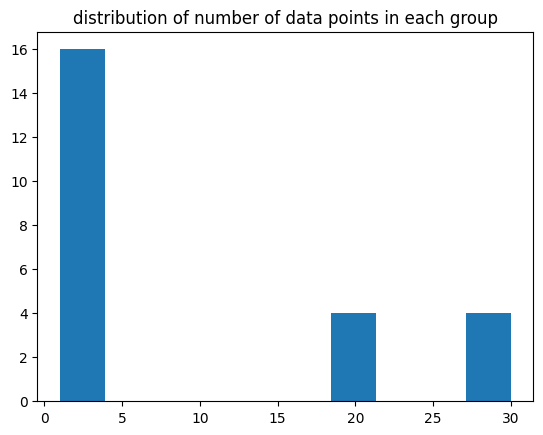

In [6]:
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df = pd.read_csv('data/dps-cleaned-missing.csv')
print(len(df))
#df.head()

cols_group = ['Project','Protein','Modality', 'Stress_Condition','Temp_C_', 'Time_Days_']
cols_feature01 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH']
cols_target = ['UP_SEC_Monomer','UP_SEC_HMW']
cols_cate = ['Buffer','NaClRange','PS80_Range','Sucrose_Range','Trehalose_Range']

# split dataframe by identifiers
is_drop_na = True
if(is_drop_na):
    n_data_th = 20
else:
    n_data_th = 30
splits_identifier = list(df[cols_group + cols_feature01+cols_target].groupby(cols_group,dropna=is_drop_na))
#splits_identifier = list(df[cols_group + cols_cate+['pH']+cols_target].groupby(cols_group,dropna=is_drop_na))
ndata = [len(df[1]) for df in splits_identifier]
ndata_str = [str(e) for e in ndata]
#print(','.join(ndata_str))
plt.hist(ndata)
plt.title('distribution of number of data points in each group')
print(max(ndata))#21

res = [idx for idx, val in enumerate(ndata) if val >= n_data_th]
print("The list of indices greater than or equal to n_data_th : " + str(res))
print(len(res))
print(np.sum(ndata))

In [7]:
split1 = splits_identifier[1]
split3 = splits_identifier[3]
split5 = splits_identifier[5]

split1_formulation_df = split1[1][cols_feature01]
split1_formulation_df.reset_index(drop = True,inplace =True)
split3_formulation_df = split3[1][cols_feature01]
split3_formulation_df.reset_index(drop = True,inplace =True)
split5_formulation_df = split5[1][cols_feature01]
split5_formulation_df.reset_index(drop = True,inplace =True)


print(split1_formulation_df.equals(split3_formulation_df))
print(split3_formulation_df.equals(split5_formulation_df))

split1_target_df = split1[1][cols_target]
split1_target_df.reset_index(drop = True,inplace =True)
split1_target_df.columns = [c+'_1' for c in split1_target_df.columns]

split3_target_df = split3[1][cols_target]
split3_target_df.reset_index(drop = True,inplace =True)
split3_target_df.columns = [c+'_3' for c in split3_target_df.columns]

split5_target_df = split5[1][cols_target]
split5_target_df.reset_index(drop = True,inplace =True)
split5_target_df.columns = [c+'_5' for c in split5_target_df.columns]


True
True


In [8]:
n21_total_df = pd.concat((split1_formulation_df,split1_target_df,split3_target_df,split5_target_df),axis = 1)
n21_total_df.head()

,Buffer,NaCl_mM_,PS80_,Sucrose_,Trehalose_,pH,UP_SEC_Monomer_1,UP_SEC_HMW_1,UP_SEC_Monomer_3,UP_SEC_HMW_3,UP_SEC_Monomer_5,UP_SEC_HMW_5
0,Acetate,0,0.0,0.0,0,5.0,98.09,1.45,97.27,1.06,95.21,3.86
1,Acetate,0,0.0,0.0,0,5.5,97.96,1.37,94.98,3.30,96.73,2.43
2,Acetate,0,0.0,0.0,0,6.0,98.15,1.24,94.86,3.60,97.36,1.82
3,Citrate,0,0.0,0.0,0,5.5,97.66,1.42,94.14,4.39,96.13,3.53
4,Citrate,0,0.0,0.0,0,6.0,98.03,1.63,94.01,4.59,96.04,2.90


In [9]:
from pandas import factorize
x_name = 'Buffer'
labels, categories = factorize(n21_total_df[x_name])
n21_total_df[x_name+"_label"] = labels

cols_feature02 = ['NaCl_mM_', 'PS80_', 'Sucrose_', 'Trehalose_', 'pH','Buffer_label']
#cols_feature02 = ['Buffer_label', 'NaCl_mM_', 'pH']

In [10]:
cols_target_new = ['UP_SEC_Monomer_1','UP_SEC_HMW_1',	'UP_SEC_Monomer_3',	'UP_SEC_HMW_3',	'UP_SEC_Monomer_5',	'UP_SEC_HMW_5']
#cols_target_new = ['UP_SEC_HMW_1','UP_SEC_LMW_1',	'UP_SEC_HMW_3',	'UP_SEC_LMW_3','UP_SEC_HMW_5','UP_SEC_LMW_5']

In [11]:
df_X = n21_total_df[cols_feature02]
df_X.head()

,NaCl_mM_,PS80_,Sucrose_,Trehalose_,pH,Buffer_label
0,0,0.0,0.0,0,5.0,0
1,0,0.0,0.0,0,5.5,0
2,0,0.0,0.0,0,6.0,0
3,0,0.0,0.0,0,5.5,1
4,0,0.0,0.0,0,6.0,1


In [12]:
df_Y = n21_total_df[cols_target_new]
df_Y.head()

,UP_SEC_Monomer_1,UP_SEC_HMW_1,UP_SEC_Monomer_3,UP_SEC_HMW_3,UP_SEC_Monomer_5,UP_SEC_HMW_5
0,98.09,1.45,97.27,1.06,95.21,3.86
1,97.96,1.37,94.98,3.30,96.73,2.43
2,98.15,1.24,94.86,3.60,97.36,1.82
3,97.66,1.42,94.14,4.39,96.13,3.53
4,98.03,1.63,94.01,4.59,96.04,2.90


In [13]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=0)
#df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=0, stratify =df_X[['PS80_','Sucrose_']])
# only one datapoint of PS90 and Sucrose are greater than 0

In [14]:
from sklearn.compose import ColumnTransformer
xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),df_X_train.columns.difference(['Buffer_label']))], 
                         remainder = 'passthrough')

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)

Create and fit the GP+ model: Firstly, we create the model using GP_Plus command, and then the model is optimized with model.fit

In [16]:
t_train_x0  = torch.rand(16,8)
t_train_y0 = torch.rand(16,6)
#qual_ind_lev = {5: 3}
gp_model0 = GP_Plus(t_train_x0, t_train_y0)

#print(gp_model0.likelihood)

#print(gp_model0.mean_module(t_train_x).shape)
#print(gp_model0.covar_module(t_train_x).shape)

gp_model_output0 = gp_model0(*gp_model0.train_inputs)
gp_lik_out0 = gp_model0.likelihood(gp_model_output0).log_prob(gp_model0.train_targets)
gp_lik_out0



mean_x_sum.shape torch.Size([16, 6])
mean_x.shape torch.Size([16, 6])
covar_x.shape torch.Size([96, 96])
ensemble_mean.shape torch.Size([16, 6])
ensemble_covar.shape torch.Size([96, 96])


/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2121.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


tensor(-125.5585, dtype=torch.float64, grad_fn=<MulBackward0>)

In [15]:
qual_ind_lev = {5: 3}
y_ind = 5
t_train_x = torch.Tensor(scaled_X_train)
#t_train_y = torch.Tensor(df_y_train.to_numpy()[:,y_ind])
t_train_y = torch.Tensor(df_y_train.to_numpy())
gp_model = GP_Plus(t_train_x, t_train_y, qual_ind_lev=qual_ind_lev)

output = gp_model(*gp_model.train_inputs)
gp_model.likelihood(output).log_prob(gp_model.train_targets)
#gp_model.likelihood(output).log_prob(gp_model.train_targets.contiguous())

/Users/chenya68/anaconda3/envs/gpplus-py39/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2121.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


tensor(-112.8575, dtype=torch.float64, grad_fn=<MulBackward0>)

In [16]:
import torch
import numpy as np
from gpytorch import settings as gptsettings
from gpytorch.utils.errors import NanError,NotPSDError
from scipy.optimize import minimize,OptimizeResult
from collections import OrderedDict
from functools import reduce
from joblib import Parallel,delayed
from joblib.externals.loky import set_loky_pickler
from typing import Dict,List,Tuple,Optional,Union
from copy import deepcopy
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint
from scipy.optimize import BFGS

from gpplus.utils.interval_score import interval_score
tkwargs = {
    "dtype": torch.float,
    "device": torch.device("cpu" if torch.cuda.is_available() else "cpu"),
}

def marginal_log_likelihood(model,add_prior:bool,regularization_parameter=[0,0]):
    output = model(*model.train_inputs)
    out = model.likelihood(output).log_prob(model.train_targets)
    if add_prior:
        # add priors
        for _, module, prior, closure, _ in model.named_priors():
            out.add_(prior.log_prob(closure(module)).sum())
    temp = 0
    temp_1=0
    for name, param in model.named_parameters():
        string_list = ['fci', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h8','h9', 'h10', 'h11', 'h12','fce']
        if name in string_list:
            temp += torch.norm(param)
            temp_1 += torch.sum(torch.abs(param))
        elif name in ['nn_model.' + str + '.bias' for str in string_list]:
            temp += torch.norm(param)
            temp_1 += torch.sum(torch.abs(param))

    out -= regularization_parameter[0]*temp_1 + regularization_parameter[1]* temp    
    ## Interval Score if neede for BO
    if model.IS is True:
        score, accuracy = interval_score(output.mean + 1.96 * output.variance.sqrt(), output.mean - 1.96 * output.variance.sqrt(), model.y_scaled)
        return out - 0.08*torch.abs(out) * score#- torch.exp(model.interval_alpha) * score
    return out 

class MLLObjective:

    def __init__(self,model,add_prior,regularization_parameter):
        self.model = model 
        self.add_prior = add_prior
        self.regularization_parameter=regularization_parameter

        parameters = OrderedDict([
            (n,p) for n,p in self.model.named_parameters() if p.requires_grad
        ])
        self.param_shapes = OrderedDict()
        for n,p in self.model.named_parameters():
            if p.requires_grad:
                if len(parameters[n].size()) > 0:
                    self.param_shapes[n] = parameters[n].size()
                else:
                    self.param_shapes[n] = torch.Size([1])
    
    def pack_parameters(self) -> np.ndarray:
        parameters = OrderedDict([
            (n,p) for n,p in self.model.named_parameters() if p.requires_grad
        ])
        
        return np.concatenate([parameters[n].cpu().data.numpy().ravel() for n in parameters])
    
    def unpack_parameters(self, x:np.ndarray) -> torch.Tensor:
        i = 0
        named_parameters = OrderedDict()
        for n in self.param_shapes:
            param_len = reduce(lambda x,y: x*y, self.param_shapes[n])
            # slice out a section of this length
            param = x[i:i+param_len]
            # reshape according to this size, and cast to torch
            param = param.reshape(*self.param_shapes[n])
            named_parameters[n] = torch.from_numpy(param).to(**tkwargs)
            # update index
            i += param_len
        return named_parameters

    def pack_grads(self) -> None:
        """Concatenate gradients from the parameters to 1D numpy array
        """
        grads = []
        for name,p in self.model.named_parameters():
            if p.requires_grad:
                grad = p.grad.cpu().data.numpy()
                grads.append(grad.ravel())
        return np.concatenate(grads).astype(np.float64)

    def fun(self, x:np.ndarray,return_grad=True) -> Union[float,Tuple[float,np.ndarray]]:
        # unpack x and load into module 
        state_dict = self.unpack_parameters(x)
        old_dict = self.model.state_dict()
        old_dict.update(state_dict)
        self.model.load_state_dict(old_dict)

        self.model.zero_grad()
        obj = -marginal_log_likelihood(self.model, self.add_prior,self.regularization_parameter) # negative sign to minimize
        
        if return_grad:
            obj.backward()
            
            return obj.item(),self.pack_grads()
        
        return obj.item()

In [17]:
def _sample_from_prior(model) -> np.ndarray:
    out = []
    for _,module,prior,closure,_ in model.named_priors():
        if not closure(module).requires_grad:
            continue
            
        out.append(prior.expand(closure(module).shape).sample().cpu().numpy().ravel())
    
    return np.concatenate(out)

In [38]:
out_prior = []
for a,module,prior,closure,b in gp_model.named_priors():
        print('-----prior-----')
        print(prior)
        print('-----closure(module)------')
        print(closure(module))
        print('-----a------')
        print(a)
        #print(b)
        if not closure(module).requires_grad:
            continue
        tmp = prior.expand(closure(module).shape).sample().cpu().numpy().ravel()    
        out_prior.append(tmp)

-----prior-----
NormalPrior()
-----closure(module)------
Parameter containing:
tensor([[-0.5125,  0.4809,  0.2351],
        [ 0.0534,  0.0958, -0.4216]], requires_grad=True)
-----a------
latent_prior_latent[5]
-----prior-----
LogHalfHorseshoePrior(scale: 0.009999999776482582, lb: 9.99999993922529e-09)
-----closure(module)------
Parameter containing:
tensor([-9.2104], requires_grad=True)
-----a------
likelihood.noise_prior
-----prior-----
NormalPrior()
-----closure(module)------
Parameter containing:
tensor([[0., 0., 0., 0., 0.]], requires_grad=True)
-----a------
covar_module.data_covar_module.kernels.1.lengthscale_prior


In [36]:
[(n,p) for (n,p) in gp_model.named_parameters()]

[('latent[5]',
  Parameter containing:
  tensor([[-0.5125,  0.4809,  0.2351],
          [ 0.0534,  0.0958, -0.4216]], requires_grad=True)),
 ('likelihood.raw_task_noises',
  Parameter containing:
  tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)),
 ('likelihood.raw_noise',
  Parameter containing:
  tensor([-9.2104], requires_grad=True)),
 ('mean_module.base_means.0.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.1.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.2.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.3.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.4.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.5.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('covar_module.task_covar_module.covar_factor',
  Para

In [29]:
#ls_named_prior = [(_,module,prior,closure,_)  for (_,module,prior,closure,_) in gp_model.named_priors()]
ls_named_prior = [n for n in gp_model.named_priors()]
#len(ls_named_prior)
for k in ls_named_prior[2]:
    print(k)

covar_module.data_covar_module.kernels.1.lengthscale_prior
RBFKernel(
  (raw_lengthscale_constraint): Positive()
  (lengthscale_prior): NormalPrior()
  (distance_module): Distance()
)
NormalPrior()
<function Module.register_prior.<locals>.closure at 0x7fda09550550>
<function Module.register_prior.<locals>.setting_closure at 0x7fda095503a0>


In [30]:
gp_model.named_priors

<bound method Module.named_priors of GP_Plus(
  (likelihood): MultitaskGaussianLikelihood(
    (raw_task_noises_constraint): GreaterThan(1.000E-08)
    (raw_noise_constraint): GreaterThan(1.000E-08)
    (noise_prior): LogHalfHorseshoePrior(scale: 0.009999999776482582, lb: 9.99999993922529e-09)
  )
  (mean_module): MultitaskMean(
    (base_means): ModuleList(
      (0): ConstantMean()
      (1): ConstantMean()
      (2): ConstantMean()
      (3): ConstantMean()
      (4): ConstantMean()
      (5): ConstantMean()
    )
  )
  (covar_module): MultitaskKernel(
    (task_covar_module): IndexKernel(
      (raw_var_constraint): Positive()
    )
    (data_covar_module): ProductKernel(
      (kernels): ModuleList(
        (0): RBFKernel(
          (raw_lengthscale_constraint): Positive()
          (distance_module): Distance()
        )
        (1): RBFKernel(
          (raw_lengthscale_constraint): Positive()
          (lengthscale_prior): NormalPrior()
          (distance_module): Distance()
 

In [31]:
def cons_f(x,likobj):
    zeta = torch.tensor(likobj.model.zeta, dtype = torch.float64)
    A = likobj.unpack_parameters(x)['fci']
    likobj.model.nn_model.fci.weight.data = A
    positions = likobj.model.nn_model(zeta)
    out_constraint=positions.detach().numpy().reshape(-1,)
    return out_constraint[0:8]

def get_bounds(likobj, theta):

    dic = likobj.unpack_parameters(theta)

    minn = np.empty(0)
    maxx = np.empty(0)
    for name, values in dic.items():
        for ii in range(len(likobj.model.qual_kernel_columns)):
            if name ==  str(likobj.model.qual_kernel_columns[ii]):
                minn = np.concatenate( (minn,  np.repeat(-3, values.numel()) ) )
                maxx = np.concatenate( (maxx,  np.repeat(3, values.numel()) ) )
        if name == 'likelihood.noise_covar.raw_noise' or name.startswith('[') or name.startswith('latent['):
            minn = np.concatenate( (minn,  np.repeat(-np.inf, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( np.inf, values.numel()) ) )
        if 'raw_lengthscale' in name:
            minn = np.concatenate( (minn,  np.repeat(-10.0, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 3.0, values.numel()) ) )
        elif name.startswith('covar_module'):
            minn = np.concatenate( (minn,  np.repeat(-10.0, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 3.0, values.numel()) ) )
            ######################################################################################### For multiple Bases ##################################
        elif name.startswith('mean'):
            minn = np.concatenate( (minn,  np.repeat(-1.5, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 1.5, values.numel()) ) )
        elif name.startswith('Theta_'):
            minn = np.concatenate( (minn,  np.repeat(-15, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 15, values.numel()) ) )
        elif name.startswith('encoder'):
            minn = np.concatenate( (minn,  np.repeat(-15, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 15, values.numel()) ) )
            ######################################################################################### For A_matrix and Variationa encoder  #################
        elif name.startswith('A_matrix'):
            minn = np.concatenate( (minn,  np.repeat(-10, values.numel()) ) )
            maxx = np.concatenate( (maxx,  np.repeat( 10, values.numel()) ) )
    return np.array(minn).reshape(-1,), np.array(maxx).reshape(-1,)


def _fit_model_from_state(likobj,theta0,jac,options, method = 'trust-constr',constraint=False,bounds=False):
    
    min, max = get_bounds(likobj, theta0)
    bounds_acts = Bounds(min, max)
    nonlinear_constraint = NonlinearConstraint(lambda x: cons_f(x, likobj), [0,0,0,0,-5,0,-5,-5],[0,0,5,0,5,5,5,5], jac='2-point', hess=BFGS())
    '''
    if constraint==True:
        nonlinear_constraint = NonlinearConstraint(lambda x: cons_f(x, likobj), [0,0,0,0,-inf,0],[0,0,inf,0,inf,inf], jac='2-point', hess=BFGS())
    
    else:
        nonlinear_constraint = NonlinearConstraint(lambda x: cons_f(x, likobj), [-inf,-inf,-inf,-inf,-inf,-inf],[inf,inf,inf,inf,inf,inf], jac='2-point', hess=BFGS())

    '''
    eq_cons = {'type': 'eq',
                'fun' : lambda x: np.array([cons_f(x, likobj)[0],cons_f(x, likobj)[1],cons_f(x, likobj)[3]])}
    ineq_cons = {'type': 'ineq',
                'fun' : lambda x: np.array([cons_f(x, likobj)[2],cons_f(x, likobj)[5]])}
    if constraint==True:
        nonlinear_constraint=[nonlinear_constraint]
    else:
        nonlinear_constraint=[]


    if bounds==True:
        bounds=bounds_acts
    else:
        bounds=None


    try:
        with gptsettings.fast_computations(log_prob=False):
            return minimize(
                fun = likobj.fun,
                x0 = theta0,
                args=(True) if jac else (False),

                method = method,
                jac=jac,
                bounds=bounds,
                constraints= nonlinear_constraint,
                #constraints=[eq_cons, ineq_cons],
                options= options 
            )


    except Exception as e:
        if isinstance(e,NotPSDError) or isinstance(e, NanError):
            # Unstable hyperparameter configuration. This can happen if the 
            # initial starting point is bad. 
            return e
        else:
            # There is some other issue, most likely with the inputs supplied
            # by the user. Raise error to indicate the problematic part.
            raise

In [32]:

#fit_model_scipy(self,add_prior,num_restarts,theta0_list,jac, options,n_jobs,method ,constraint,bounds,regularization_parameter)



add_prior:bool=True
num_restarts:int=1
theta0_list:Optional[List[np.ndarray]]=None
jac:bool=True
options:Dict={}
n_jobs = 1
method = 'L-BFGS-B'
constraint=False
bounds=False
regularization_parameter:List[int]=[0,0]

if method == 'L-BFGS-B':
        defaults = {'ftol':1e-6,'gtol':1e-5,'maxfun':5000,'maxiter':2000}

if len(options) > 0:
        for key in options.keys():
            if key not in defaults.keys():
                raise RuntimeError('Unknown option %s!'%key)
            defaults[key] = options[key]

likobj = MLLObjective(gp_model,add_prior,regularization_parameter)


if theta0_list is None:
        theta0_list = [likobj.pack_parameters()]
        if num_restarts > -1:
            theta0_list.extend([_sample_from_prior(gp_model) for _ in range(num_restarts+1)])
            #theta0_list.pop(0) 

In [33]:
parameters = OrderedDict([
            (n,p) for n,p in likobj.model.named_parameters() if p.requires_grad
        ])
#parameters       
tmp = np.concatenate([parameters[n].cpu().data.numpy().ravel() for n in parameters])
tmp.shape

(36,)

In [34]:
[(n,p) for (n,p) in gp_model.named_parameters()]

[('latent[5]',
  Parameter containing:
  tensor([[-0.5125,  0.4809,  0.2351],
          [ 0.0534,  0.0958, -0.4216]], requires_grad=True)),
 ('likelihood.raw_task_noises',
  Parameter containing:
  tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)),
 ('likelihood.raw_noise',
  Parameter containing:
  tensor([-9.2104], requires_grad=True)),
 ('mean_module.base_means.0.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.1.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.2.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.3.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.4.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.base_means.5.constant',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('covar_module.task_covar_module.covar_factor',
  Para

In [35]:
theta0 = theta0_list[0]
likobj.param_shapes

OrderedDict([('latent[5]', torch.Size([2, 3])),
             ('likelihood.raw_task_noises', torch.Size([6])),
             ('likelihood.raw_noise', torch.Size([1])),
             ('mean_module.base_means.0.constant', torch.Size([1])),
             ('mean_module.base_means.1.constant', torch.Size([1])),
             ('mean_module.base_means.2.constant', torch.Size([1])),
             ('mean_module.base_means.3.constant', torch.Size([1])),
             ('mean_module.base_means.4.constant', torch.Size([1])),
             ('mean_module.base_means.5.constant', torch.Size([1])),
             ('covar_module.task_covar_module.covar_factor',
              torch.Size([6, 1])),
             ('covar_module.task_covar_module.raw_var', torch.Size([6])),
             ('covar_module.data_covar_module.kernels.1.raw_lengthscale',
              torch.Size([1, 5]))])

In [43]:
if True:
        x = theta0
        i = 0
        named_parameters = OrderedDict()
        for n in likobj.param_shapes:
            #print(n)
            param_len = reduce(lambda x,y: x*y, likobj.param_shapes[n])
            #print('param_len',param_len)
            # slice out a section of this length
            param = x[i:i+param_len]
            # reshape according to this size, and cast to torch
            param = param.reshape(*likobj.param_shapes[n])
            named_parameters[n] = torch.from_numpy(param).to(**tkwargs)
            # update index
            i += param_len

In [44]:
likobj.fun(theta0)

(141.3231512264697,
 array([ 3.49273872, -5.30238485,  1.6735425 ,  3.23938227, -0.0525011 ,
        -2.75574279,  5.01273203,  5.63015842,  6.08272457,  5.79794407,
         4.72798491,  6.07177448, -0.80268836, -2.20350766, -0.19663157,
        -2.63312912, -0.87176365, -1.85206854, -0.62226838, -1.6824882 ,
         1.1328187 , -0.17626889, -0.50256026,  2.06249142,  0.19219288,
         0.42347366,  1.11890411,  0.625745  ,  1.21735036,  0.34964919,
         1.18314683,  4.22098923,  0.33333334,  0.33333334,  0.33333334,
         7.33378696]))

In [51]:
theta0_list[0]

array([ 5.3834844e-01, -5.0322598e-01, -1.7122632e-01,  5.7237506e-01,
       -6.8722069e-02, -7.2514474e-02,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
       -9.2104406e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -1.3558062e+00,
        9.1286159e-01,  4.3602367e-03, -3.6886990e-01,  1.7588873e+00,
        1.8035872e-01,  3.1083274e-01, -9.2658818e-02, -5.6834060e-01,
        1.8647309e-01, -3.4179326e-02, -2.2391362e-01,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

In [52]:
theta0_list[1]

array([ 0.49681157,  1.0336995 , -1.8137964 ,  0.51856875, -1.0298015 ,
       -2.500112  , -5.153781  , -4.830361  , -1.4799149 , -3.9835544 ,
       -3.6200075 ,  0.96849537], dtype=float32)

In [50]:
theta0 = theta0_list[1]
_fit_model_from_state(likobj,theta0,jac,defaults,method,constraint,bounds)

ValueError: cannot reshape array of size 0 into shape (1,)

In [47]:
out = [_fit_model_from_state(likobj,theta0,jac,defaults,method,constraint,bounds) for theta0 in theta0_list]

ValueError: cannot reshape array of size 0 into shape (1,)

In [46]:
out = Parallel(n_jobs=1,verbose=0)(
        delayed(_fit_model_from_state)(likobj,theta0,jac,defaults, method,constraint,bounds) \
            for theta0 in theta0_list
    )

ValueError: cannot reshape array of size 0 into shape (1,)

In [19]:
gp_model.fit(bounds=True)

## Learning the model's parameters has started ##


ValueError: cannot reshape array of size 0 into shape (1,)

In [271]:
gp_model = GP_Plus(t_train_x, t_train_y, qual_ind_lev=qual_ind_lev)
#gp_model.mean_module(t_train_x).shape
output = gp_model(gp_model.train_inputs[0])
output.covariance_matrix.shape
#out = gp_model.likelihood(output).log_prob(gp_model.train_targets)

mean_x_sum.shape torch.Size([16, 6])
x_new.shape torch.Size([16, 7])
mean_x.shape torch.Size([16, 6])
covar_x.shape torch.Size([96, 96])
ensemble_mean.shape torch.Size([16, 6])
ensemble_covar.shape torch.Size([96, 96])


torch.Size([96, 96])

In [272]:
gp_model.likelihood(output)
#gp_model.likelihood(output).covariance_matrix.shape

MultitaskMultivariateNormal(loc: torch.Size([96]))

In [185]:
x_train_cate_zeta = gp_model.transform_categorical(t_train_x[:,5].clone().type(torch.int64).to('cpu'),perm_dict = gp_model.perm_dict[0], zeta = gp_model.zeta[0])
x_train_cate_latent = gp_model.A_matrix[0](x_train_cate_zeta.float().to('cpu'))
print(x_train_cate_latent)
#ls_x_train_cate_latent.append(x_train_cate_latent.detach().numpy())

tensor([[-0.1945, -0.3865],
        [-0.1005,  0.0977],
        [ 0.2374,  0.2996],
        [ 0.2374,  0.2996],
        [ 0.2374,  0.2996],
        [-0.1005,  0.0977],
        [-0.1945, -0.3865],
        [-0.1005,  0.0977],
        [ 0.2374,  0.2996],
        [ 0.2374,  0.2996],
        [ 0.2374,  0.2996],
        [ 0.2374,  0.2996],
        [-0.1005,  0.0977],
        [-0.1945, -0.3865],
        [-0.1005,  0.0977],
        [-0.1945, -0.3865]], grad_fn=<MmBackward0>)


In [187]:
t_test_x = torch.Tensor(scaled_X_test)
x_test_cate_zeta = gp_model.transform_categorical(t_test_x[:,5].clone().type(torch.int64).to('cpu'),perm_dict = gp_model.perm_dict[0], zeta = gp_model.zeta[0])
x_test_cate_latent = gp_model.A_matrix[0](x_test_cate_zeta.float().to('cpu'))
print(x_test_cate_latent)
#ls_x_test_cate_latent.append(x_test_cate_latent.detach().numpy())

tensor([[ 0.2374,  0.2996],
        [-0.1005,  0.0977],
        [ 0.2374,  0.2996],
        [-0.1945, -0.3865],
        [-0.1945, -0.3865]], grad_fn=<MmBackward0>)


In [98]:
np.save('data/train_cate_latent.npy',np.array(ls_x_train_cate_latent),allow_pickle= True)
np.save('data/test_cate_latent.npy',np.array(ls_x_test_cate_latent),allow_pickle= True)

In [52]:
i = 0
A = model.A_matrix
zeta = model.zeta[i]
positions = A[i](x=zeta.float().to('cpu'))
#positions.shape
level = torch.max(model.perm[i]+1, axis = 0)[0].tolist()
levels = level
perm = model.perm[i]
constraints_flag=False

In [53]:
positions

tensor([[-0.7605, -0.1799],
        [ 0.3098,  0.0732],
        [ 0.4512,  0.1057]], grad_fn=<MmBackward0>)

In [173]:
#x_cate_zeta is the prior embedding for all categorical observations
#x_cate_latent are the latent variable values
i = 0
x_cate_zeta= transform_categorical(x=x[:,qual_kernel_columns[i]].clone().type(torch.int64).to('cpu'), 
                        perm_dict = self_perm_dict[i], zeta = self_zeta[i])
x_cate_latent = model.A_matrix[i](x_cate_zeta.float().to('cpu'))
print(x_cate_zeta.shape)
print(x_cate_latent.shape)

torch.Size([100, 10])
torch.Size([100, 2])


In [180]:
x_cate_latent.unique().sort()

torch.return_types.sort(
values=tensor([-2.6171e-01, -2.1992e-01, -1.9734e-01, -1.8409e-01, -1.8275e-01,
        -1.6436e-01, -1.5461e-01, -1.5303e-01, -8.1902e-02, -6.7315e-02,
        -5.5410e-02, -4.8922e-02, -4.1810e-02, -3.9174e-02, -3.7587e-02,
        -1.3620e-02, -1.9610e-05,  2.2210e-02,  2.4985e-02,  3.5810e-02,
         3.7321e-02,  4.8047e-02,  5.3546e-02,  6.6776e-02,  6.8133e-02,
         8.6527e-02,  8.9838e-02,  9.6275e-02,  9.7861e-02,  1.0261e-01,
         1.2567e-01,  1.5986e-01,  1.7444e-01,  1.9284e-01,  2.0258e-01,
         2.0417e-01,  2.4362e-01,  2.5722e-01,  2.7274e-01,  2.8069e-01,
         2.9528e-01,  3.1367e-01,  3.2342e-01,  3.4708e-01,  4.7904e-01,
         4.9264e-01,  5.5943e-01,  5.8249e-01], grad_fn=<SortBackward0>),
indices=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]))

In [184]:
positions.unique().sort()

torch.return_types.sort(
values=tensor([-2.6171e-01, -2.1992e-01, -1.9734e-01, -1.8409e-01, -1.8275e-01,
        -1.6436e-01, -1.5461e-01, -1.5303e-01, -8.1902e-02, -6.7315e-02,
        -5.5410e-02, -4.8922e-02, -4.1810e-02, -3.9174e-02, -3.7587e-02,
        -1.3620e-02, -1.9610e-05,  2.2210e-02,  2.4985e-02,  3.5810e-02,
         3.7321e-02,  4.8047e-02,  5.3546e-02,  6.6776e-02,  6.8133e-02,
         8.6527e-02,  8.9838e-02,  9.6275e-02,  9.7861e-02,  1.0261e-01,
         1.2567e-01,  1.5986e-01,  1.7444e-01,  1.9284e-01,  2.0258e-01,
         2.0417e-01,  2.4362e-01,  2.5722e-01,  2.7274e-01,  2.8069e-01,
         2.9528e-01,  3.1367e-01,  3.2342e-01,  3.2401e-01,  3.2500e-01,
         3.4708e-01,  4.7904e-01,  4.9264e-01,  5.5943e-01,  5.8249e-01],
       grad_fn=<SortBackward0>),
indices=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_4050/3697863923.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', 20)  # Get a colormap from matplotlib, 'tab20' has nice distinct colors


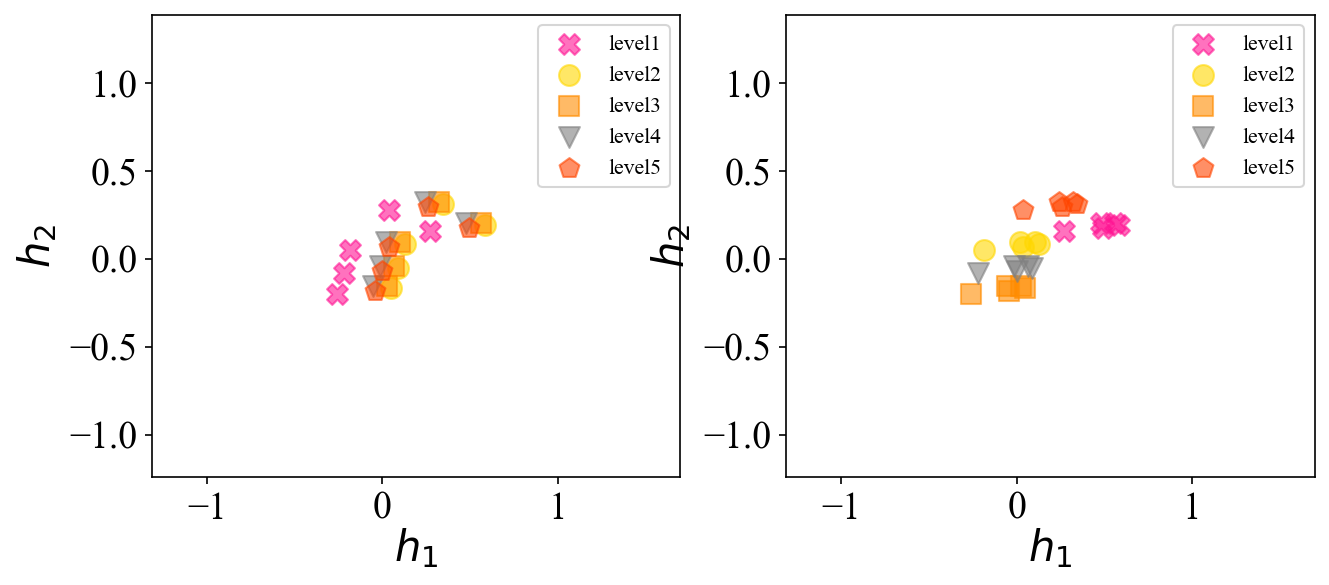

In [165]:
type = 'cat'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
colors_base = ['deeppink', 'gold', 'darkorange', 'gray', 'orangered', 'blue']
cmap = cm.get_cmap('tab20', 20)  # Get a colormap from matplotlib, 'tab20' has nice distinct colors
colors = colors_base  + [cmap(i) for i in range(len(colors_base), 20)]
marker = ['X','o','s',"v", 'p', 'v', '^', '<', '>','*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_','1', '2', '3', '4',]
positions = positions.cpu().detach().numpy()

if len(levels) > 1:
        fig,axs = plt.subplots(1, len(levels),figsize=(10,4))
        for j in range(len(levels)):
            for i in range(levels[j]):
                index = torch.where(perm[:,j] == i) 
                if i<=10:
                    fontsize=5
                    s_size=100
                else:
                    fontsize=5
                    s_size=100
                if  type=='mf':
                    axs[j].scatter(positions[index][...,0], positions[index][...,1], label = legend[i], color = colors[i], marker=marker[i],s=s_size,alpha=.6)#marker=r'$\clubsuit$'
                    plt.xlabel(r'$z_1$',labelpad=0,rotation=0,fontsize=20)
                    plt.ylabel(r'$z_2$',labelpad=10,rotation=0, fontsize=20)
                
                elif type=='cat':
                    axs[j].scatter(positions[index][...,0], positions[index][...,1], label = 'level' + str(i+1), color = colors[i], marker=marker[i],s=s_size,alpha=.6)#marker=r'$\clubsuit$'
                    axs[j].set_xlabel(r'$h_1$', labelpad=0, fontsize=20)
                    axs[j].set_ylabel(r'$h_2$', labelpad=5,fontsize=20)
                else:
                    raise ValueError("type should be either 'mf' or cat:")
                # plt.tight_layout()
                # axs[j].legend()
                axs[j].legend(loc='upper right', fontsize='xx-small')

                tempxi = np.min(positions[...,0])-0.2 * (np.abs(np.min(positions[...,0])) +5)
                tempxx = np.max(positions[...,0]) + 0.2 * (np.abs(np.max(positions[...,0])) +5)
                tempyi = np.min(positions[...,1])-0.2 * (np.abs(np.min(positions[...,1])) +5)
                tempyx = np.max(positions[...,1]) + 0.2 * (np.abs(np.max(positions[...,1])) +5)
                axs[j].set_xlim(tempxi, tempxx)
                axs[j].set_ylim(tempyi, tempyx)

Visualization and evaluation: As this is a mixed-space problem, we use the 'model.visualize_latent()' command to visualize the learnt latent space of the categorical features.

Then, the accuarcy of the model is evaluated using 'model.evaluation(); command

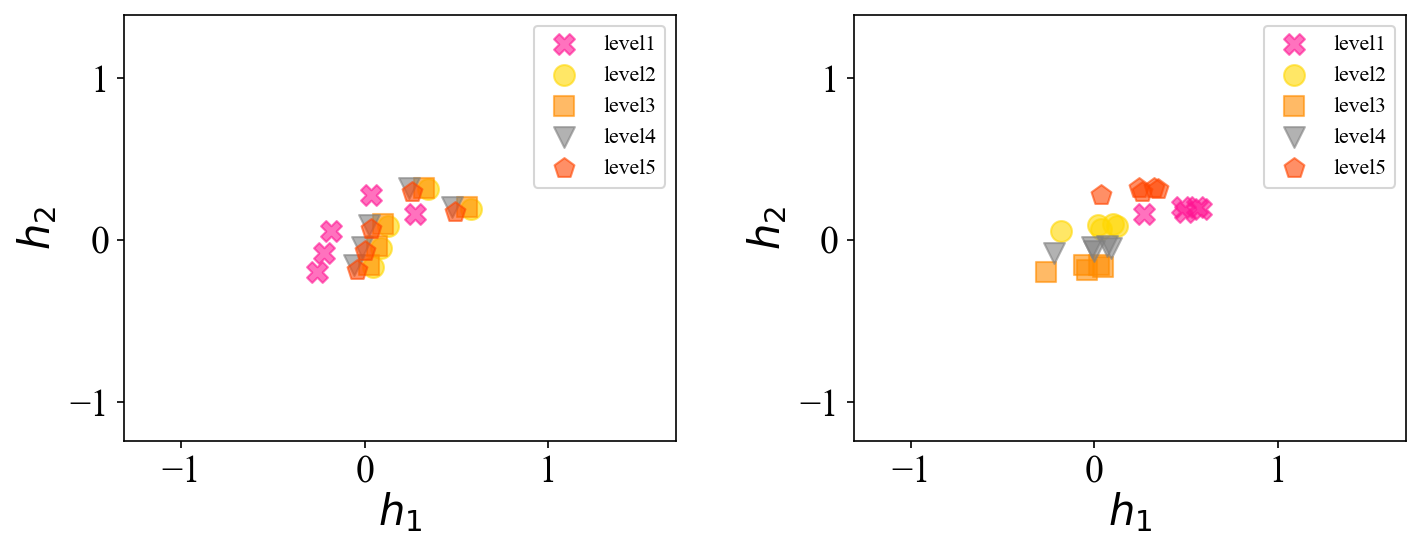

In [144]:
model.visualize_latent()
#model.evaluation(Utest, ytest)